In [1]:
import os

# Check standard Singularity environment variables
singularity_name = os.getenv('SINGULARITY_NAME', 'Not inside a Singularity container')
singularity_container = os.getenv('SINGULARITY_CONTAINER', 'Unknown container')

print(f"Container Name: {singularity_name}")
print(f"Container Identifier: {singularity_container}")

Container Name: single_cell_analysis_2025-03-04.sif
Container Identifier: /pscratch/mteb223_uksr/phdo222/single_cell_data/single_cell_analysis_2025-03-04.sif


In [2]:
import io
import tempfile
from anndata import AnnData
import muon
import numpy as np
import requests
import os
import scanpy as sc
import scvi
import seaborn as sns
import torch
import pandas as pd
import sys
import scrublet as scr
import skimage
import pybiomart
from bioservices import BioMart
import rdata
import matplotlib.pyplot as plt
from adjustText import adjust_text
from scipy.stats import beta
import leidenalg
import igraph
import tqdm
import time
import gc
import polars as pl
import pyarrow
import mygene

/opt/conda/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/opt/conda/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [3]:
from importlib.metadata import version, PackageNotFoundError
import importlib.util
import pkg_resources

# Function to safely get package versions
def get_package_version(package_name):
    try:
        return version(package_name)
    except PackageNotFoundError:
        try:
            return pkg_resources.get_distribution(package_name).version
        except pkg_resources.DistributionNotFound:
            return "Not Installed"

# List of installable packages to check
packages = [
    'anndata', 'muon', 'numpy', 'scanpy', 'scvi-tools', 'seaborn', 'torch',
    'pandas', 'scrublet', 'scikit-image', 'pybiomart', 'bioservices', 'rdata',
    'matplotlib', 'adjustText', 'scipy', 'leidenalg', 'igraph', 'gseapy',
    'statsmodels', 'joblib', 'cellphonedb', 'rpy2', 'goatools', 'polars', 'pyarrow',
    'mygene'
]

# List of built-in modules to check
builtin_modules = ['io', 'sys', 'os', 'multiprocessing', 'gc', 'importlib']

# Retrieve and print versions for installable packages
for pkg in packages:
    print(f"{pkg} version:", get_package_version(pkg))

# Check for built-in modules
for module in builtin_modules:
    is_available = importlib.util.find_spec(module) is not None
    print(f"{module} module:", "Available" if is_available else "Not Available")

anndata version: 0.11.3
muon version: 0.1.7
numpy version: 2.1.3
scanpy version: 1.11.0
scvi-tools version: 1.3.0
seaborn version: 0.13.2
torch version: 2.6.0
pandas version: 2.2.3
scrublet version: 0.2.3
scikit-image version: 0.25.2
pybiomart version: 0.2.0
bioservices version: 1.12.1
rdata version: 0.11.2
matplotlib version: 3.10.1
adjustText version: 1.3.0
scipy version: 1.15.2
leidenalg version: 0.10.2
igraph version: 0.11.8
gseapy version: 1.1.6
statsmodels version: 0.14.4
joblib version: 1.4.2
cellphonedb version: 5.0.1
rpy2 version: 3.5.17
goatools version: 1.4.12
polars version: 1.24.0
pyarrow version: 19.0.1
mygene version: 3.2.2
io module: Available
sys module: Available
os module: Available
multiprocessing module: Available
gc module: Available
importlib module: Available


/tmp/ipykernel_1148512/3929775529.py:3: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [ ]:
import polars as pl
import os

# Define file paths
split_folder = "Data_Split_by_Sample/Parquet_Files"
gene_file = os.path.join(split_folder, "PBMC_gene_counts_filter1_02262025_04292025.raw.parquet")
iso_file = os.path.join(split_folder, "PBMC_isoform_counts_02262025_04292025.raw.parquet")

# Check if the file exists
if not os.path.exists(iso_file):
    print(f"❌ Error: Isoform file '{iso_file}' not found.")
else:
    try:
        # Load the Parquet file using Polars
        iso_data = pl.read_parquet(iso_file)
        print("✅ Isoform File loaded successfully.")
        print(iso_data.head())  # Show first few rows to verify

    except Exception as e:
        print(f"❌ Error loading isoform file: {e}")

        # Check if the file exists
if not os.path.exists(gene_file):
    print(f"❌ Error: Gene file '{gene_file}' not found.")
else:
    try:
        # Load the Parquet file using Polars
        gene_data = pl.read_parquet(gene_file)
        print("✅ Gene File loaded successfully.")
        print(gene_data.head())  # Show first few rows to verify

    except Exception as e:
        print(f"❌ Error loading gene file: {e}")

In [ ]:
print(iso_data.shape)
print(gene_data.shape)

In [ ]:
import polars as pl
import os

# Define file paths
split_folder = "Data_Split_by_Sample/Parquet_Files"

# os.makedirs(split_folder, exist_ok=True)

## Split the dataset by sample and save as .parquet
def split_and_save_by_sample_gene(dfg):
    # Identify columns for each sample
    pbmc1_cols = [col for col in dfg.columns if col.startswith("PBMC1")]
    pbmc2_cols = [col for col in dfg.columns if col.startswith("PBMC2")]
    gene_col = [dfg.columns[0]]  # Assuming the first column is metadata

    # Extract each sample with metadata
    pbmc1_df = dfg.select(gene_col + pbmc1_cols)
    pbmc2_df = dfg.select(gene_col + pbmc2_cols)

    # Save as .parquet files
    pbmc1_path = os.path.join(split_folder, "PBMC1_gene_raw_04292025.parquet")
    pbmc2_path = os.path.join(split_folder, "PBMC2_gene_raw_04292025.parquet")
    gene_id_path = os.path.join(split_folder, "gene_IDs_04292025.parquet")

    pbmc1_df.write_parquet(pbmc1_path, compression="zstd", compression_level=4)
    pbmc2_df.write_parquet(pbmc2_path, compression="zstd", compression_level=4)

    # Convert gene column to a DataFrame before saving
    gene_id_df = dfg.select(gene_col)
    gene_id_df.write_parquet(gene_id_path, compression="zstd", compression_level=4)

    print(f"PBMC1 sample saved at: {pbmc1_path}")
    print(f"PBMC2 sample saved at: {pbmc2_path}")
    print(f"GeneIDs saved at: {gene_id_path}")

# Example usage
dfg = gene_data  # Ensure 'gene_data' is defined before calling this function
split_and_save_by_sample_gene(dfg)

In [ ]:
## Define file paths
split_folder = "Data_Split_by_Sample/Parquet_Files"
#os.makedirs(split_folder, exist_ok=True)

## Split the dataset by sample and save as .parquet
def split_and_save_by_sample_iso(dfi):
    # Identify metadata and transcript columns
    iso_cols = ["GENEID", "TXNAME"]
    pbmc1_cols = [col for col in dfi.columns if col.startswith("PBMC1")]
    pbmc2_cols = [col for col in dfi.columns if col.startswith("PBMC2")]

    # Ensure metadata columns exist in the dataset
    iso_cols = [col for col in iso_cols if col in dfi.columns]

    # Extract each sample with metadata
    pbmc1_df = dfi.select(iso_cols + pbmc1_cols)
    pbmc2_df = dfi.select(iso_cols + pbmc2_cols)

    # Save as .parquet files
    pbmc1_path = os.path.join(split_folder, "PBMC1_iso_raw_04292025.parquet")
    pbmc2_path = os.path.join(split_folder, "PBMC2_iso_raw_04292025.parquet")
    iso_id_path = os.path.join(split_folder, "iso_IDs_04292025.parquet")

    pbmc1_df.write_parquet(pbmc1_path, compression="zstd", compression_level=4)
    pbmc2_df.write_parquet(pbmc2_path, compression="zstd", compression_level=4)

    # Convert iso column to a DataFrame before saving
    iso_id_df = dfi.select(iso_cols)
    iso_id_df.write_parquet(iso_id_path, compression="zstd", compression_level=4)

    print(f"✅ PBMC1 transcript data saved at: {pbmc1_path}")
    print(f"✅ PBMC2 transcript data saved at: {pbmc2_path}")
    print(f"✅ isoform IDs saved at: {iso_id_path}")

# Example usage
dfi = iso_data
split_and_save_by_sample_iso(dfi)

In [ ]:
#!/usr/bin/env python3
import pandas as pd

# 1) Read the GTF into a DataFrame
gtf = pd.read_csv(
    "Homo_sapiens.GRCh38.113.gtf",
    sep="\t",
    comment="#",
    header=None,
    names=[
        "seqname", "source", "feature", "start", "end",
        "score", "strand", "frame", "attribute"
    ],
    dtype={"attribute": str},
)

# 2) Extract the fields we care about via regex on the 'attribute' column
#    (these correspond to the str_match(...) in your mutate calls)
gtf["transcript_id"]     = gtf["attribute"].str.extract(r'transcript_id "([^"]+)"')
gtf["gene_id"]           = gtf["attribute"].str.extract(r'gene_id "([^"]+)"')
gtf["gene_name"]   = gtf["attribute"].str.extract(r'gene_name "([^"]+)"')

# 3) Filter for transcript‐level entries with valid ENSG/ENST IDs
tx = (
    gtf[
        (gtf["feature"] == "transcript") &
        gtf["gene_id"].str.startswith("ENSG", na=False) &
        gtf["transcript_id"].str.startswith("ENST", na=False)
    ]
    .loc[:, ["transcript_id", "gene_id", "gene_name"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

# 4) Write out the transcript‐level table
tx.to_csv("transcript_annotation_key_info.tsv", sep="\t", index=False)

# --- If you also want the gene‐level table as in your earlier snippet: ---
genes = (
    gtf[
        (gtf["feature"] == "gene") &
        gtf["gene_id"].str.startswith("ENSG", na=False)
    ]
    .loc[:, ["gene_id", "gene_name"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

genes.to_csv("gene_annotation_key_info.tsv", sep="\t", index=False)

In [ ]:
PBMC1_iso = pl.read_parquet("Data_Split_by_Sample/Parquet_Files/PBMC1_iso_raw_04292025.parquet")
PBMC2_iso = pl.read_parquet("Data_Split_by_Sample/Parquet_Files/PBMC2_iso_raw_04292025.parquet")
isoID = pl.read_parquet("Data_Split_by_Sample/Parquet_Files/iso_IDs_04292025.parquet")

# Load the transcript‐level table
iso_annot = pl.read_csv("transcript_annotation_key_info.tsv", separator="\t")

In [ ]:
PBMC1_gene = pl.read_parquet("Data_Split_by_Sample/Parquet_Files/PBMC1_gene_raw_04292025.parquet")
PBMC2_gene = pl.read_parquet("Data_Split_by_Sample/Parquet_Files/PBMC2_gene_raw_04292025.parquet")
geneID = pl.read_parquet("Data_Split_by_Sample/Parquet_Files/gene_IDs_04292025.parquet")
# Load the gene‐level table
gene_annot = pl.read_csv("gene_annotation_key_info.tsv", separator="\t")

In [ ]:
print(iso_annot.head())

In [ ]:
print(gene_annot.head())

In [ ]:
# 🧬 Annotate gene-level data
def annotate_gene_table(df: pl.DataFrame,
                          gene_col: str = "GENEID") -> pl.DataFrame:
    return df.join(
        gene_annot,
        left_on  = [gene_col],
        right_on = ["gene_id"],
        how       = "left",
        suffix    = "_anno"
    )

In [ ]:
# 🧬 Annotate isoform-level data
def annotate_isoform_table(df: pl.DataFrame,
                          gene_col: str = "GENEID",
                          tx_col:   str = "TXNAME") -> pl.DataFrame:
    return df.join(
        iso_annot,
        left_on  = [gene_col, tx_col],
        right_on = ["gene_id", "transcript_id"],
        how       = "left",
        suffix    = "_anno"
    )

In [ ]:
# Annotate your base data
annotated_gene_df = annotate_gene_table(geneID)
annotated_iso_df = annotate_isoform_table(isoID)

In [ ]:
annotated_gene_df.head

In [ ]:
annotated_iso_df.head

In [ ]:
# Check for duplicated TXNAMEs in your isoform-level dataframe
duplicates = (
    annotated_iso_df
    .group_by("TXNAME")
    .agg(pl.len().alias("count"))
    .filter(pl.col("count") > 1)
    .sort("count", descending=True)
)

print(f"🔍 Found {duplicates.shape[0]} duplicated TXNAMEs.")
print(duplicates)

In [ ]:
# Check for duplicated TXNAMEs in your gene-level dataframe
duplicates = (
    annotated_gene_df
    .group_by("GENEID")
    .agg(pl.len().alias("count"))
    .filter(pl.col("count") > 1)
    .sort("count", descending=True)
)

print(f"🔍 Found {duplicates.shape[0]} duplicated GENEIDs.")
print(duplicates)

In [ ]:
# 🔹 Remove duplicate rows
iso_anno = annotated_isoform_df.unique(keep="first")
gene_anno = annotated_gene_df.unique(keep="first")

print("✅ Table cleanup completed successfully.")

In [ ]:
print(PBMC1_iso.head())
print(PBMC2_iso.head())
print(PBMC1_gene.head())
print(PBMC2_gene.head())
print(geneID.head())
print(isoID.head())

In [ ]:
print(gene_annot.head())
print(gene_annot.shape)

In [ ]:
print(iso_annot.head())
print(iso_annot.shape)

In [ ]:
# Save outputs
split_dir = "Data_Split_by_Sample/Parquet_Files"

gene_path = os.path.join(split_dir, "gene_annotation_04302025.parquet")
iso_path = os.path.join(split_dir, "iso_annotation_04302025.parquet")

iso_annot.write_parquet(iso_path, compression="zstd")
gene_annot.write_parquet(gene_path, compression="zstd")

In [ ]:
PBMC1_iso = pl.read_parquet("Data_Split_by_Sample/Parquet_Files/PBMC1_iso_raw_04292025.parquet")
PBMC2_iso = pl.read_parquet("Data_Split_by_Sample/Parquet_Files/PBMC2_iso_raw_04292025.parquet")
isoID = pl.read_parquet("Data_Split_by_Sample/Parquet_Files/iso_IDs_04292025.parquet")
iso_anno = pl.read_parquet("Data_Split_by_Sample/Parquet_Files/iso_annotation_04302025.parquet")

In [ ]:
PBMC1_gene = pl.read_parquet("Data_Split_by_Sample/Parquet_Files/PBMC1_gene_raw_04292025.parquet")
PBMC2_gene = pl.read_parquet("Data_Split_by_Sample/Parquet_Files/PBMC2_gene_raw_04292025.parquet")
geneID = pl.read_parquet("Data_Split_by_Sample/Parquet_Files/gene_IDs_04292025.parquet")
gene_anno = pl.read_parquet("Data_Split_by_Sample/Parquet_Files/gene_annotation_04302025.parquet")

In [ ]:
print("gene annotation columns:",gene_anno.columns)
print("iso annotation columns:",iso_anno.columns)

In [ ]:
print(gene_anno.head())
print(geneID.head())

In [ ]:
print(iso_anno.head())
print(isoID.head())

In [ ]:
print(geneID.shape)
print(PBMC1_gene.shape)
print(PBMC2_gene.shape)

In [ ]:
print(isoID.shape)
print(PBMC1_iso.shape)
print(PBMC2_iso.shape)

In [ ]:
import polars as pl
import pandas as pd

# Convert Polars DataFrames to Pandas
PBMC1_iso = PBMC1_iso.to_pandas()
PBMC2_iso = PBMC2_iso.to_pandas()
isoID = isoID.to_pandas()
iso_anno = iso_anno.to_pandas()

In [ ]:
# Convert Polars DataFrames to Pandas
PBMC1_gene = PBMC1_gene.to_pandas()
PBMC2_gene = PBMC2_gene.to_pandas()
geneID = geneID.to_pandas()
gene_anno = gene_anno.to_pandas()

In [ ]:
def count_features(df):
    # figure out row/col counts in a framework-agnostic way
    if hasattr(df, "height") and hasattr(df, "width"):
        # Polars DataFrame
        n_rows, n_cols = df.height, df.width
        cols = df.columns
    else:
        # pandas DataFrame
        n_rows, n_cols = df.shape
        cols = list(df.columns)

    # if the first column looks like a feature ID, assume each row is a feature
    if cols[0].upper() == "GENEID" or (len(cols) > 1 and cols[1].upper() == "TXNAME"):
        n_features = n_rows
        # and the rest of the columns are cells
        n_cells = sum(1 for c in cols[1:] if c.startswith("PBMC"))
    else:
        # otherwise assume columns are features and rows are cells
        n_features = sum(1 for c in cols if c.startswith("PBMC"))
        n_cells    = n_rows

    return n_features, n_cells

In [ ]:
for name, tbl in [
    ("PBMC1_gene", PBMC1_gene),
    ("PBMC2_gene", PBMC2_gene),
]:
    ng, nc = count_features(tbl)
    print(f"🔍 {name}: {ng} features, {nc} cells")

In [ ]:
for name, tbl in [
    ("PBMC1_iso",  PBMC1_iso),
    ("PBMC2_iso",  PBMC2_iso),
]:
    ng, nc = count_features(tbl)
    print(f"🔍 {name}: {ng} features, {nc} cells")

In [ ]:
# ✅ Merge gene‐level annotation
gene_ID = geneID.merge(
    gene_anno,
    left_on="GENEID",    # column in geneID
    right_on="gene_id",  # column in gene_anno
    how="left",
)
# fill any missing gene_name
gene_ID["gene_name"] = gene_ID["gene_name"].fillna("")

In [ ]:
# ✅ Merge isoform‐level annotation
iso_ID = isoID.merge(
    iso_anno,
    left_on = ["GENEID", "TXNAME"],           # columns in isoID
    right_on= ["gene_id", "transcript_id"],   # columns in iso_anno
    how="left",
)
iso_ID["gene_name"] = iso_ID["gene_name"].fillna("")

# (optional) drop the duplicated join‐key columns if you only need the original ones:
# gene_ID = gene_ID.drop(columns=["gene_id"])
# iso_ID  = iso_ID .drop(columns=["gene_id","transcript_id"])

In [ ]:
print(iso_ID.shape)
print(gene_ID.shape)

In [ ]:
def create_combined_gene_id(row):
    geneid = row["GENEID"]
    symbol = row.get("gene_name", "") or ""

    # 1️⃣ If this is a true Ensembl gene (GENEID starts with "ENSG"),
    #    always include the Ensembl ID—and prepend the symbol if we have one:
    if geneid.startswith("ENSG"):
        if symbol:
            return f"{symbol}:{geneid}"
        else:
            return f"{geneid}"

    # 2️⃣ Otherwise, if we have any human symbol (e.g. came from an ENSG match),
    #    include it:
    if symbol:
        return f"{symbol}:{geneid}"

    # 3️⃣ Finally, for entirely novel Bambu loci with no symbol:
    return f"{geneid}"

In [ ]:
def create_combined_iso_id(row):
    geneid = row["GENEID"]
    txname = row["TXNAME"]
    symbol = row.get("gene_name", "") or ""

    # 1️⃣ If this is a true Ensembl gene (GENEID starts with "ENSG"),
    #    always include the Ensembl ID—and prepend the symbol if we have one—
    #    even if the transcript name is a Bambu one:
    if geneid.startswith("ENSG"):
        if symbol:
            return f"{symbol}:{geneid}:{txname}"
        else:
            return f"{geneid}:{txname}"

    # 2️⃣ Otherwise, if we have any human symbol (e.g. came from an ENSG match),
    #    include it:
    if symbol:
        return f"{symbol}:{geneid}:{txname}"

    # 3️⃣ Finally, for entirely novel Bambu loci with no symbol:
    return f"{geneid}:{txname}"

In [ ]:
# 🧠 Apply functions
gene_ID["combined_IDs"] = gene_ID.apply(create_combined_gene_id, axis=1)

# ✅ Remove true duplicates
gene_ID = gene_ID.sort_values("GENEID").drop_duplicates(subset=["GENEID"])

# ✅ Sanity check
print("\n✅ Combined IDs created.")
print("\n🔍 Gene ID structure:")
print(gene_ID.head())


In [ ]:
iso_ID["combined_IDs"] = iso_ID.apply(create_combined_iso_id, axis=1)
iso_ID = iso_ID.sort_values(["GENEID", "TXNAME"]).drop_duplicates(subset=["GENEID", "TXNAME"])

# ✅ Sanity check
print("\n✅ Combined IDs created.")
print("\n🔍 Isoform ID structure:")
print(iso_ID.head())

In [ ]:
# ✅ Sort full gene-level DataFrames by GENEID
PBMC1_gene_sorted = PBMC1_gene.sort_values("GENEID")
PBMC2_gene_sorted = PBMC2_gene.sort_values("GENEID")
geneID_sorted = gene_ID.sort_values("GENEID")

# ✅ Extract GENEID columns for comparison
PBMC1_gene_ids = PBMC1_gene_sorted["GENEID"].tolist()
PBMC2_gene_ids = PBMC2_gene_sorted["GENEID"].tolist()
geneID_list   = geneID_sorted["GENEID"].tolist()

# ✅ Compare gene-level order
if PBMC1_gene_ids == PBMC2_gene_ids == geneID_list:
    print("✅ GENEID order is consistent across gene datasets.")
else:
    print("❗ GENEID order differs across gene datasets.")

In [ ]:
# ✅ Sort full isoform-level DataFrames by GENEID and TXNAME
PBMC1_iso_sorted = PBMC1_iso.sort_values(["GENEID", "TXNAME"])
PBMC2_iso_sorted = PBMC2_iso.sort_values(["GENEID", "TXNAME"])
isoID_sorted    = iso_ID.sort_values(["GENEID", "TXNAME"])

# ✅ Extract combined GENEID+TXNAME tuples for comparison
PBMC1_iso_keys = list(zip(PBMC1_iso_sorted["GENEID"], PBMC1_iso_sorted["TXNAME"]))
PBMC2_iso_keys = list(zip(PBMC2_iso_sorted["GENEID"], PBMC2_iso_sorted["TXNAME"]))
isoID_keys    = list(zip(isoID_sorted["GENEID"], isoID_sorted["TXNAME"]))

# ✅ Compare isoform-level order
if PBMC1_iso_keys == PBMC2_iso_keys == isoID_keys:
    print("✅ GENEID + TXNAME order is consistent across isoform datasets.")
else:
    print("❗ GENEID + TXNAME order differs across isoform datasets.")

In [ ]:
%who

In [ ]:
%reset_selective PBMC1_iso_keys PBMC2_iso_keys PBMC1_gene_keys PBMC2_gene_keys PBMC1_gene PBMC2_gene PBMC1_iso PBMC2_iso create_combined_gene_id create_combined_iso_id geneID geneID_list gene_ID gene_anno isoID iso_ID isoID_keys

In [ ]:
%who

In [ ]:
PBMC1_gene_sorted.head

In [ ]:
PBMC1_iso_sorted.head

In [ ]:
# Insert combined_IDs as the first column in each dataset
PBMC1_gene_sorted.insert(0, "combined_IDs", geneID_sorted["combined_IDs"].values)
PBMC2_gene_sorted.insert(0, "combined_IDs", geneID_sorted["combined_IDs"].values)
print("\n✅ Combined IDs inserted as first column.")

In [ ]:
# Insert combined_IDs as the first column in each dataset
PBMC1_iso_sorted.insert(0, "combined_IDs", isoID_sorted["combined_IDs"].values)
PBMC2_iso_sorted.insert(0, "combined_IDs", isoID_sorted["combined_IDs"].values)

print("\n✅ Combined IDs inserted as first column.")

In [ ]:
print(PBMC1_gene_sorted.head)
print(PBMC2_gene_sorted.head)
print(PBMC1_iso_sorted.head)
print(PBMC2_iso_sorted.head)

In [ ]:
def count_features(df):
    """
    Return (n_features, n_cells) based on whether features live in rows
    (first col is a feature ID) or in columns.
    Works on both pandas.DataFrame and pl.DataFrame.
    """
    # detect Polars vs pandas
    if isinstance(df, pl.DataFrame):
        n_rows, n_cols = df.shape
        cols = df.columns
    else:
        n_rows, n_cols = df.shape
        cols = list(df.columns)

    # If first column is a feature ID, features are rows.
    # Now we treat either "combined_IDs" or "GENEID" as feature-ID column.
    first = cols[0].upper()
    second = cols[1].upper() if len(cols) > 1 else ""
    if first in ("GENEID", "COMBINED_IDS") or second == "TXNAME":
        n_features = n_rows
        # the rest of the columns are cells
        n_cells = sum(1 for c in cols[1:] if isinstance(c, str) and c.startswith("PBMC"))
    else:
        # otherwise features are columns, and rows are cells
        n_features = sum(1 for c in cols if isinstance(c, str) and c.startswith("PBMC"))
        n_cells    = n_rows

    return n_features, n_cells


In [ ]:
def needs_inversion(df):
    """
    Return True if the DataFrame needs to be transposed
    so that features become rows (i.e. n_features matches #columns).
    """
    n_features, _ = count_features(df)
    # df.shape[0] is #rows for both pandas and polars
    return n_features == df.shape[0]

def transpose_df(df):
    """Transpose a DataFrame, handling pandas vs polars."""
    if isinstance(df, pl.DataFrame):
        # Polars 0.16+ has transpose()
        return df.transpose(include_header=True)
    else:
        return df.T.copy()

In [ ]:
# 2) Quick QC: how many features & cells?
for name, tbl in [
    ("PBMC1_gene", PBMC1_gene_sorted),
    ("PBMC2_gene", PBMC2_gene_sorted),
]:
    ng, nc = count_features(tbl)
    print(f"🔍 {name}: {ng} features, {nc} cells")

# 3) Decide which need transposing
decisions = {
    "PBMC1_gene": needs_inversion(PBMC1_gene_sorted),
    "PBMC2_gene": needs_inversion(PBMC2_gene_sorted),
}
print("\n📌 Inversion needed?")
for name, inv in decisions.items():
    print(f"  • {name}: {inv}")

In [ ]:
# 2) Quick QC: how many features & cells?
for name, tbl in [
    ("PBMC1_iso",  PBMC1_iso_sorted),
    ("PBMC2_iso",  PBMC2_iso_sorted),
]:
    ng, nc = count_features(tbl)
    print(f"🔍 {name}: {ng} features, {nc} cells")

# 3) Decide which need transposing
decisions = {
    "PBMC1_iso":  needs_inversion(PBMC1_iso_sorted),
    "PBMC2_iso":  needs_inversion(PBMC2_iso_sorted),
}
print("\n📌 Inversion needed?")
for name, inv in decisions.items():
    print(f"  • {name}: {inv}")

In [ ]:
# 4) Apply transpose where needed
PBMC1_gene = transpose_df(PBMC1_gene_sorted) if decisions["PBMC1_gene"] else PBMC1_gene_sorted
PBMC2_gene = transpose_df(PBMC2_gene_sorted) if decisions["PBMC2_gene"] else PBMC2_gene_sorted
print("\n✅ Finished applying any necessary transpositions.")

In [ ]:
# 4) Apply transpose where needed
PBMC1_iso  = transpose_df(PBMC1_iso_sorted ) if decisions["PBMC1_iso" ] else PBMC1_iso_sorted
PBMC2_iso  = transpose_df(PBMC2_iso_sorted ) if decisions["PBMC2_iso" ] else PBMC2_iso_sorted

print("\n✅ Finished applying any necessary transpositions.")

In [ ]:
print(PBMC1_gene.shape)
print(PBMC1_gene.head)
print(PBMC2_gene.shape)
print(PBMC2_gene.head)

In [ ]:
print(PBMC1_iso.shape)
print(PBMC1_iso.head)
print(PBMC2_iso.shape)
print(PBMC2_iso.head)

In [ ]:
print("\n🔍 First 10 values of PBMC1_geneT first column (should be cell names):")
print(PBMC1_gene.iloc[:, 0].head(10))
print(PBMC1_gene.shape)

In [ ]:
(PBMC1_gene.index[:10]) #If index is already set, it will be cell names. If it is not, it will be numbers 

In [ ]:
# Extract gene names from the header row
gene_names_1 = PBMC1_gene.iloc[0, 0:].tolist()
gene_names_2 = PBMC2_gene.iloc[0, 0:].tolist()

print(gene_names_1[:5])
print(gene_names_2[:5])

In [ ]:
iso_names_1 = PBMC1_iso.iloc[0, 0:].tolist()
iso_names_2 = PBMC2_iso.iloc[0, 0:].tolist()
print(iso_names_1[:5])
print(iso_names_2[:5])

In [ ]:
# Extract cell names from the index row (skipping the first two rows)
cell_names_1 = PBMC1_gene.index.tolist()[2:]
cell_names_2 = PBMC2_gene.index.tolist()[2:]
print(cell_names_1[:5])
print(cell_names_2[:5])

In [ ]:
cell_names_3 = PBMC1_iso.index.tolist()[3:]
cell_names_4 = PBMC2_iso.index.tolist()[3:]
print(cell_names_3[:5])
print(cell_names_4[:5])

In [ ]:
# Extract the numeric matrix from row 2 onward and from column 2 onward
PBMC1_gene_data = PBMC1_gene.iloc[2:, 0:].copy()
PBMC2_gene_data = PBMC2_gene.iloc[2:, 0:].copy()

# Now assign gene names to the rows (index) and cell names to the columns
PBMC1_gene_data.index = cell_names_1
PBMC1_gene_data.columns = gene_names_1
PBMC2_gene_data.index = cell_names_2
PBMC2_gene_data.columns = gene_names_2

print("\n🔍 PBMC1_gene index sample (should be cell names):")
print(PBMC1_gene_data.index[:5])  # First 5 index values to verify

print("\n🔍 PBMC1_gene index sample (should be gene names):")
print(PBMC1_gene_data.columns[:5])  # First 5 index values to verify

print("\n✅ Final Index Verification")
print("PBMC1_gene index type:", type(PBMC1_gene_data.index))

In [ ]:
# Extract the numeric matrix from row 3 onward and from column 0 onward
PBMC1_iso_data = PBMC1_iso.iloc[3:, 0:].copy()
PBMC2_iso_data = PBMC2_iso.iloc[3:, 0:].copy()

# Now assign gene names to the rows (index) and cell names to the columns
PBMC1_iso_data.index = cell_names_3
PBMC1_iso_data.columns = iso_names_1
PBMC2_iso_data.index = cell_names_4
PBMC2_iso_data.columns = iso_names_2

# ✅ Final Verification
print("\n🔍 PBMC1_iso index sample (should be cell names):")
print(PBMC1_iso.index[:5])  # First 5 index values to verify

print("\n🔍 PBMC2_iso index sample (should be cell names):")
print(PBMC2_iso.index[:5])  # First 5 index values to verify

print("\n✅ Final Index Verification")
print("PBMC1_iso index type:", type(PBMC1_iso_data.index))

print("\n✅ Final processing complete. Cells are rows, genes/isoforms are columns.")

In [ ]:
print(PBMC1_gene_data.shape)
print(PBMC1_gene_data.head())

In [ ]:
## Ensure all data types are correct
PBMC1_gene_data = PBMC1_gene_data.astype(float)
PBMC2_gene_data = PBMC2_gene_data.astype(float)

In [ ]:
## Ensure all data types are correct
PBMC1_iso_data = PBMC1_iso_data.astype(float)
PBMC2_iso_data = PBMC2_iso_data.astype(float)

In [ ]:
print(PBMC1_gene_data.shape)
print(PBMC1_gene_data.head())
print("\n🔍 PBMC1_gene index sample (should be cell names):")
print(PBMC1_gene_data.index[:5])  # First 5 index values to verify

print("\n🔍 PBMC1_gene index sample (should be gene names):")
print(PBMC1_gene_data.columns[:5])  # First 5 index values to verify

In [ ]:
# Save outputs
split_dir = "Intermediate_Files/QC_Figs_04302025"

gene1_path = os.path.join(split_dir, "PBMC1_gene_ReadyForAnndata_04302025.pkl")
gene2_path = os.path.join(split_dir, "PBMC2_gene_ReadyForAnndata_04302025.pkl")

PBMC1_gene_data.to_pickle(gene1_path)
PBMC2_gene_data.to_pickle(gene2_path)

In [ ]:
# Save outputs
split_dir = "Intermediate_Files/QC_Figs_04302025"

iso1_path = os.path.join(split_dir, "PBMC1_iso_ReadyForAnndata_04302025.pkl")
iso2_path = os.path.join(split_dir, "PBMC2_iso_ReadyForAnndata_04302025.pkl")

PBMC1_iso_data.to_pickle(iso1_path)
PBMC2_iso_data.to_pickle(iso2_path)

In [21]:
import pickle

# Dictionary mapping your desired names to file paths
file_paths = {
    "PBMC2_iso": "Intermediate_Files/QC_Figs_04302025/PBMC2_iso_ReadyForAnndata_04302025.pkl",
    "PBMC1_iso": "Intermediate_Files/QC_Figs_04302025/PBMC1_iso_ReadyForAnndata_04302025.pkl",
    "PBMC2_gene": "Intermediate_Files/QC_Figs_04302025/PBMC2_gene_ReadyForAnndata_04302025.pkl",
    "PBMC1_gene": "Intermediate_Files/QC_Figs_04302025/PBMC1_gene_ReadyForAnndata_04302025.pkl"
}

# Load each file and store the result in a dictionary
loaded_data = {}

for name, path in file_paths.items():
    with open(path, "rb") as f:
        loaded_data[name] = pickle.load(f)

# Now you can access the loaded objects using the keys:
# loaded_data["PBMC2_iso"], loaded_data["PBMC1_iso"], etc.
print("Loaded files:", list(loaded_data.keys()))

Loaded files: ['PBMC2_iso', 'PBMC1_iso', 'PBMC2_gene', 'PBMC1_gene']


In [22]:
PBMC2_iso = loaded_data["PBMC2_iso"]
PBMC1_iso = loaded_data["PBMC1_iso"]
PBMC2_gene = loaded_data["PBMC2_gene"]
PBMC1_gene = loaded_data["PBMC1_gene"]

In [23]:
# Sort the columns of the raw count matrix by column names for PBMC1_iso_data
PBMC1_iso = PBMC1_iso.sort_index(axis=0)
PBMC2_iso = PBMC2_iso.sort_index(axis=0)

# Sort the columns of the raw count matrix by column names for PBMC1_gene_data
PBMC2_gene = PBMC2_gene.sort_index(axis=0)
PBMC1_gene = PBMC1_gene.sort_index(axis=0)

In [24]:
# Check if row names match exactly
rows_match = PBMC1_iso.index.equals(PBMC1_gene.index)

# Output TRUE if they match, FALSE if they don't
print("PBMC1 Gene and Isoform Rows match exactly:", rows_match)

PBMC1 Gene and Isoform Rows match exactly: True


In [25]:
# Check if row names match exactly
rows_match = PBMC2_iso.index.equals(PBMC2_gene.index)

# Output TRUE if they match, FALSE if they don't
print("PBMC2 Gene and Isoform Rows match exactly:", rows_match)

PBMC2 Gene and Isoform Rows match exactly: True


In [26]:
## Create a DataFrame for gene IDs (var)
var_1 = pd.DataFrame(index=PBMC1_gene.columns, data={'gene_ids': PBMC1_gene.columns})
var_2 = pd.DataFrame(index=PBMC2_gene.columns, data={'gene_ids': PBMC2_gene.columns})

# Create a DataFrame for iso IDs (var)
var_3 = pd.DataFrame(index=PBMC1_iso.columns, data={'isoform_ids': PBMC1_iso.columns})
var_4 = pd.DataFrame(index=PBMC2_iso.columns, data={'isoform_ids': PBMC2_iso.columns})

In [27]:
## Identify duplicate gene IDs in PBMC1 and PBMC2
duplicates_1 = var_1.index[var_1.index.duplicated()].unique()
duplicates_2 = var_2.index[var_2.index.duplicated()].unique()

## Print the duplicate gene IDs
print("Duplicate gene IDs in PBMC1_gene_data:")
print(duplicates_1)

print("Duplicate gene IDs in PBMC2_gene_data:")
print(duplicates_2)

## Identify duplicate gene IDs in PBMC1 and PBMC2
duplicates_3 = var_3.index[var_3.index.duplicated()].unique()
duplicates_4 = var_4.index[var_4.index.duplicated()].unique()

# Print the duplicate gene IDs
print("Duplicate gene IDs in PBMC1_iso_data:")
print(duplicates_3)

print("Duplicate gene IDs in PBMC2_iso_data:")
print(duplicates_4)

Duplicate gene IDs in PBMC1_gene_data:
Index([], dtype='object')
Duplicate gene IDs in PBMC2_gene_data:
Index([], dtype='object')
Duplicate gene IDs in PBMC1_iso_data:
Index([], dtype='object')
Duplicate gene IDs in PBMC2_iso_data:
Index([], dtype='object')


In [30]:
## Create a DataFrame for cell IDs (obs)
obs_1 = pd.DataFrame(index=PBMC1_gene.index, data={'cell_ids': PBMC1_gene.index})
obs_2 = pd.DataFrame(index=PBMC2_gene.index, data={'cell_ids': PBMC2_gene.index})

obs_3 = pd.DataFrame(index=PBMC1_iso.index, data={'cell_ids': PBMC1_iso.index})
obs_4 = pd.DataFrame(index=PBMC2_iso.index, data={'cell_ids': PBMC2_iso.index})

In [28]:
from scipy.sparse import csr_matrix

#Convert to sparse matrices
PBMC1_gene_data = csr_matrix(PBMC1_gene)
PBMC2_gene_data = csr_matrix(PBMC2_gene)
PBMC1_iso_data = csr_matrix(PBMC1_iso)
PBMC2_iso_data = csr_matrix(PBMC2_iso)

In [31]:
# Create AnnData objects
PBMC1_gene = AnnData(X=PBMC1_gene_data, var=var_1, obs=obs_1)
PBMC2_gene = AnnData(X=PBMC2_gene_data, var=var_2, obs=obs_2)

PBMC1_iso = AnnData(X=PBMC1_iso_data, var=var_3, obs=obs_3)
PBMC2_iso = AnnData(X=PBMC2_iso_data, var=var_4, obs=obs_4)

In [32]:
# Print the AnnData objects
print("PBMC1_gene AnnData Object:", PBMC1_gene)
print("PBMC2_gene AnnData Object:", PBMC2_gene)
print("PBMC1_iso AnnData Object:", PBMC1_iso)
print("PBMC2_iso AnnData Object:", PBMC2_iso)

PBMC1_gene AnnData Object: AnnData object with n_obs × n_vars = 32939 × 25756
    obs: 'cell_ids'
    var: 'gene_ids'
PBMC2_gene AnnData Object: AnnData object with n_obs × n_vars = 42393 × 25756
    obs: 'cell_ids'
    var: 'gene_ids'
PBMC1_iso AnnData Object: AnnData object with n_obs × n_vars = 32939 × 97885
    obs: 'cell_ids'
    var: 'isoform_ids'
PBMC2_iso AnnData Object: AnnData object with n_obs × n_vars = 42393 × 97885
    obs: 'cell_ids'
    var: 'isoform_ids'


In [33]:
int_folder = "Intermediate_Files/QC_Figs_04302025"

# File paths with properly formatted names
pbmc1_g_path = os.path.join(int_folder, "PBMC1_gene_AnnData_04302025.h5ad")
pbmc2_g_path = os.path.join(int_folder, "PBMC2_gene_AnnData_04302025.h5ad")
pbmc1_i_path = os.path.join(int_folder, "PBMC1_iso_AnnData_04302025.h5ad")
pbmc2_i_path = os.path.join(int_folder, "PBMC2_iso_AnnData_04302025.h5ad")

PBMC1_gene.write_h5ad(pbmc1_g_path, compression="gzip")
PBMC2_gene.write_h5ad(pbmc2_g_path, compression="gzip")
PBMC1_iso.write_h5ad(pbmc1_i_path, compression="gzip")
PBMC2_iso.write_h5ad(pbmc2_i_path, compression="gzip")

In [34]:
from anndata import read_h5ad

# Define the folder path
folder_path = "Intermediate_Files/QC_Figs_04302025"

# Load the AnnData objects
PBMC1_gene = read_h5ad(os.path.join(folder_path, "PBMC1_gene_AnnData_04302025.h5ad"))
PBMC2_gene = read_h5ad(os.path.join(folder_path, "PBMC2_gene_AnnData_04302025.h5ad"))
PBMC1_iso = read_h5ad(os.path.join(folder_path, "PBMC1_iso_AnnData_04302025.h5ad"))
PBMC2_iso = read_h5ad(os.path.join(folder_path, "PBMC2_iso_AnnData_04302025.h5ad"))

# Verify the structure
print(PBMC1_gene)
print(PBMC2_gene)
print(PBMC1_iso)
print(PBMC2_iso)

AnnData object with n_obs × n_vars = 32939 × 25756
    obs: 'cell_ids'
    var: 'gene_ids'
AnnData object with n_obs × n_vars = 42393 × 25756
    obs: 'cell_ids'
    var: 'gene_ids'
AnnData object with n_obs × n_vars = 32939 × 97885
    obs: 'cell_ids'
    var: 'isoform_ids'
AnnData object with n_obs × n_vars = 42393 × 97885
    obs: 'cell_ids'
    var: 'isoform_ids'


In [35]:
# Add sample labels to each dataset for grouping in plots
PBMC1_gene.obs['sample'] = 'PBMC1'
PBMC2_gene.obs['sample'] = 'PBMC2'
PBMC1_iso.obs['sample'] = 'PBMC1'
PBMC2_iso.obs['sample'] = 'PBMC2'

In [36]:
# Combine PBMC1 and PBMC2 datasets for plotting
import anndata as ad  # Import anndata explicitly

combined_gene = ad.concat([PBMC1_gene, PBMC2_gene], join="inner")
combined_iso = ad.concat([PBMC1_iso, PBMC2_iso], join="inner")

In [37]:
# Define quality control thresholds per cell
mt_upper_threshold = 15
hb_lower_threshold = 3
hb_upper_threshold = 100 #95
total_counts_lower_threshold = 500
total_counts_upper_threshold = 11000
n_genes_lower_threshold = 250
n_genes_upper_threshold = 2500
n_isoforms_lower_threshold = 350
n_isoforms_upper_threshold = 4000

In [38]:
# Initial cell counts
init_cell_counts_1g = PBMC1_gene.n_obs
init_cell_counts_2g = PBMC2_gene.n_obs
init_cell_counts_1i = PBMC1_iso.n_obs
init_cell_counts_2i = PBMC2_iso.n_obs

init_cell_counts_df = pd.DataFrame({
    'Sample': ['PBMC1 Gene', 'PBMC2 Gene', 'PBMC1 Iso', 'PBMC2 Iso'],
    'Initial Cell #': [init_cell_counts_1g, init_cell_counts_2g, init_cell_counts_1i, init_cell_counts_2i]
})

print(init_cell_counts_df)

       Sample  Initial Cell #
0  PBMC1 Gene           32939
1  PBMC2 Gene           42393
2   PBMC1 Iso           32939
3   PBMC2 Iso           42393


In [39]:
# Function to plot QC metrics with thresholds
def plot_violin_with_thresholds(adata, metric, title, lower_thresh=None, upper_thresh=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))  # Create a new figure if no axis is provided
    
    sns.violinplot(x='sample', y=metric, data=adata.obs, inner=None, ax=ax)
    sns.stripplot(x='sample', y=metric, data=adata.obs, color='k', jitter=True, size=1.5, alpha=0.3, ax=ax)
    
    if lower_thresh is not None:
        ax.axhline(y=lower_thresh, color='r', linestyle='--', label=f'Lower Threshold ({lower_thresh})')
    if upper_thresh is not None:
        ax.axhline(y=upper_thresh, color='r', linestyle='--', label=f'Upper Threshold ({upper_thresh})')

    ax.set_title(title)
    ax.legend() 


In [40]:
# Identify hemoglobin genes and mitochondrial genes
for dataset in [combined_gene, 
                combined_iso, 
                PBMC1_gene, PBMC2_gene, 
                PBMC1_iso, PBMC2_iso]:
    dataset.var['mt'] = dataset.var_names.str.startswith("MT-")
    dataset.var['hb'] = dataset.var_names.str.contains("^HB[^(P)]")

In [41]:
# Calculate quality control (QC) metrics
for dataset in [combined_gene, 
                combined_iso, 
                PBMC1_gene, PBMC2_gene, 
                PBMC1_iso, PBMC2_iso]:
    sc.pp.calculate_qc_metrics(dataset, qc_vars=["mt", "hb"], percent_top=None, inplace=True, log1p=True)

In [42]:
# Rename the QC metric columns for isoform data in PBMC1 and PBMC2
combined_iso.obs.rename(
    columns={
        "n_genes_by_counts": "n_isoforms_by_counts",
        "total_counts": "total_counts_isoforms",
        "log1p_total_counts": "log1p_total_counts_isoforms"
    },
    inplace=True
)

PBMC1_iso.obs.rename(
    columns={
        "n_genes_by_counts": "n_isoforms_by_counts",
        "total_counts": "total_counts_isoforms",
        "log1p_total_counts": "log1p_total_counts_isoforms"
    },
    inplace=True
)

PBMC2_iso.obs.rename(
    columns={
        "n_genes_by_counts": "n_isoforms_by_counts",
        "total_counts": "total_counts_isoforms",
        "log1p_total_counts": "log1p_total_counts_isoforms"
    },
    inplace=True
)

# Verify the renamed columns in isoform datasets
print(combined_iso.obs.head())

                                                                        cell_ids  \
PBMC1_AAAAAAAAAACACAAA_filtered_mapq_10  PBMC1_AAAAAAAAAACACAAA_filtered_mapq_10   
PBMC1_AAAAAAACATATAGGC_filtered_mapq_10  PBMC1_AAAAAAACATATAGGC_filtered_mapq_10   
PBMC1_AAAAAAACATCCAGTG_filtered_mapq_10  PBMC1_AAAAAAACATCCAGTG_filtered_mapq_10   
PBMC1_AAAAAAAGATAGATCC_filtered_mapq_10  PBMC1_AAAAAAAGATAGATCC_filtered_mapq_10   
PBMC1_AAAAAAAGCAGGAACA_filtered_mapq_10  PBMC1_AAAAAAAGCAGGAACA_filtered_mapq_10   

                                        sample  n_isoforms_by_counts  \
PBMC1_AAAAAAAAAACACAAA_filtered_mapq_10  PBMC1                  2047   
PBMC1_AAAAAAACATATAGGC_filtered_mapq_10  PBMC1                  1229   
PBMC1_AAAAAAACATCCAGTG_filtered_mapq_10  PBMC1                   101   
PBMC1_AAAAAAAGATAGATCC_filtered_mapq_10  PBMC1                   201   
PBMC1_AAAAAAAGCAGGAACA_filtered_mapq_10  PBMC1                    77   

                                         log1p_n_genes_by_coun

In [43]:
# Calculate the number of cells in which each gene is detected
PBMC1_gene_counts = np.sum(PBMC1_gene.X > 0, axis=0)

# If gene_counts is a sparse matrix, convert it to a dense array
if isinstance(PBMC1_gene_counts, np.matrix):
    PBMC1_gene_counts = np.array(PBMC1_gene_counts).flatten()

# Calculate the number of cells in which each gene is detected
PBMC2_gene_counts = np.sum(PBMC2_gene.X > 0, axis=0)

# If gene_counts is a sparse matrix, convert it to a dense array
if isinstance(PBMC2_gene_counts, np.matrix):
    PBMC2_gene_counts = np.array(PBMC2_gene_counts).flatten()

    # Calculate the number of cells in which each isoform is detected
PBMC1_iso_counts = np.sum(PBMC1_iso.X > 0, axis=0)

# If isoform_counts is a sparse matrix, convert it to a dense array
if isinstance(PBMC1_iso_counts, np.matrix):
    PBMC1_iso_counts = np.array(PBMC1_iso_counts).flatten()

        # Calculate the number of cells in which each isoform is detected
PBMC2_iso_counts = np.sum(PBMC2_iso.X > 0, axis=0)

# If isoform_counts is a sparse matrix, convert it to a dense array
if isinstance(PBMC2_iso_counts, np.matrix):
    PBMC2_iso_counts = np.array(PBMC2_iso_counts).flatten()

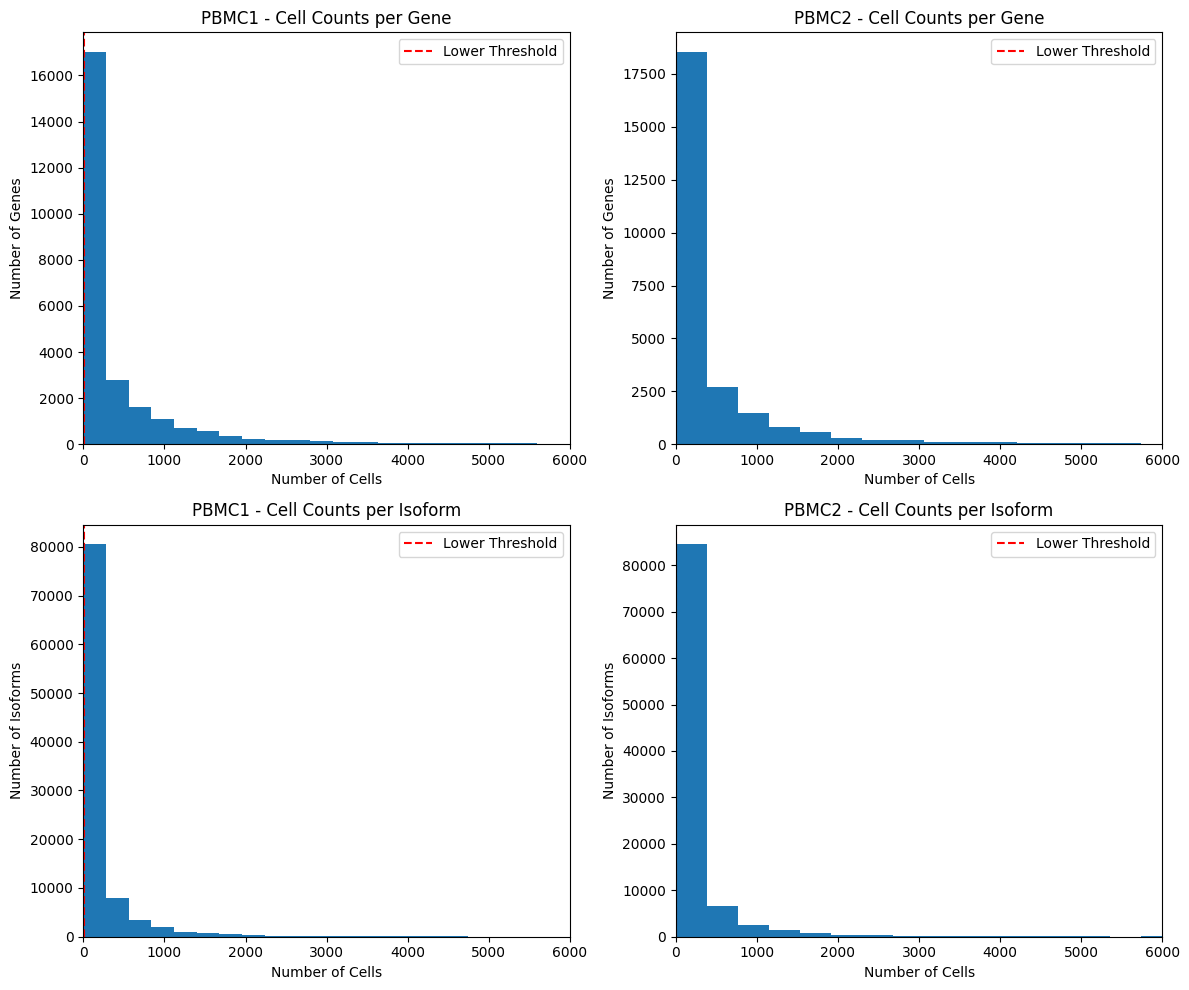

In [44]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # Use subplots properly

# Plot the distribution of cell counts per gene for PBMC1
axs[0, 0].hist(PBMC1_gene_counts, bins=100)
axs[0, 0].set_xlabel('Number of Cells')
axs[0, 0].set_ylabel('Number of Genes')
axs[0, 0].set_xlim(0, 6000)
axs[0, 0].set_title('PBMC1 - Cell Counts per Gene')
axs[0, 0].axvline(5, color='r', linestyle='--', label='Lower Threshold')
axs[0, 0].legend()

# Plot the distribution of cell counts per gene for PBMC2
axs[0, 1].hist(PBMC2_gene_counts, bins=100)
axs[0, 1].set_xlabel('Number of Cells')
axs[0, 1].set_ylabel('Number of Genes')
axs[0, 1].set_xlim(0, 6000)
axs[0, 1].set_title('PBMC2 - Cell Counts per Gene')
axs[0, 1].axvline(5, color='r', linestyle='--', label='Lower Threshold')
axs[0, 1].legend()

# Plot the distribution of cell counts per isoform for PBMC1
axs[1, 0].hist(PBMC1_iso_counts, bins=100)
axs[1, 0].set_xlabel('Number of Cells')
axs[1, 0].set_ylabel('Number of Isoforms')
axs[1, 0].set_xlim(0, 6000)
axs[1, 0].set_title('PBMC1 - Cell Counts per Isoform')
axs[1, 0].axvline(5, color='r', linestyle='--', label='Lower Threshold')
axs[1, 0].legend()

# Plot the distribution of cell counts per isoform for PBMC2
axs[1, 1].hist(PBMC2_iso_counts, bins=100)
axs[1, 1].set_xlabel('Number of Cells')
axs[1, 1].set_ylabel('Number of Isoforms')
axs[1, 1].set_xlim(0, 6000)
axs[1, 1].set_title('PBMC2 - Cell Counts per Isoform')
axs[1, 1].axvline(5, color='r', linestyle='--', label='Lower Threshold')
axs[1, 1].legend()

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [45]:
# Calculate the number of cells in which each gene is detected
PBMC1_gene_counts = np.sum(PBMC1_gene.X > 0, axis=0)

# If gene_counts is a sparse matrix, convert it to a dense array
if isinstance(PBMC1_gene_counts, np.matrix):
    PBMC1_gene_counts = np.array(PBMC1_gene_counts).flatten()

# Calculate the number of cells in which each gene is detected
PBMC2_gene_counts = np.sum(PBMC2_gene.X > 0, axis=0)

# If gene_counts is a sparse matrix, convert it to a dense array
if isinstance(PBMC2_gene_counts, np.matrix):
    PBMC2_gene_counts = np.array(PBMC2_gene_counts).flatten()

# Calculate the number of cells in which each gene is detected
PBMC1_iso_counts = np.sum(PBMC1_iso.X > 0, axis=0)

# If gene_counts is a sparse matrix, convert it to a dense array
if isinstance(PBMC1_iso_counts, np.matrix):
    PBMC1_iso_counts = np.array(PBMC1_iso_counts).flatten()

    # Calculate the number of cells in which each gene is detected
PBMC2_iso_counts = np.sum(PBMC2_iso.X > 0, axis=0)

# If gene_counts is a sparse matrix, convert it to a dense array
if isinstance(PBMC2_iso_counts, np.matrix):
    PBMC2_iso_counts = np.array(PBMC2_iso_counts).flatten()

In [46]:
# Identify genes detected in fewer than the lower threshold of cells (e.g., 10 cells)
lower_threshold = 10
PBMC1_genes_to_remove = PBMC1_gene.var_names[PBMC1_gene_counts < lower_threshold]
PBMC2_genes_to_remove = PBMC2_gene.var_names[PBMC2_gene_counts < lower_threshold]

# Display the genes that will be removed
print("Genes to remove from PBMC1:", PBMC1_genes_to_remove)
print("Genes to remove from PBMC2:", PBMC2_genes_to_remove)

Genes to remove from PBMC1: Index(['BambuGene15308', 'BambuGene17422', 'BambuGene20803', 'BambuGene2289',
       'BambuGene26922', 'BambuGene3478', 'BambuGene47881', 'BambuGene51887',
       'BambuGene54122', 'BambuGene55046',
       ...
       'ENSG00000310411', 'ENSG00000310415', 'ENSG00000310418',
       'ENSG00000310419', 'ENSG00000310436', 'ENSG00000310463',
       'ENSG00000310485', 'ENSG00000310487', 'ENSG00000310519',
       'ENSG00000310537'],
      dtype='object', length=3254)
Genes to remove from PBMC2: Index(['BambuGene17422', 'BambuGene20803', 'BambuGene2289', 'BambuGene26006',
       'BambuGene26922', 'BambuGene3478', 'BambuGene46578', 'BambuGene47881',
       'BambuGene4821', 'BambuGene50415',
       ...
       'ENSG00000310415', 'ENSG00000310418', 'ENSG00000310436',
       'ENSG00000310463', 'ENSG00000310485', 'ENSG00000310487',
       'ENSG00000310519', 'ENSG00000310525', 'ENSG00000310535',
       'ENSG00000310537'],
      dtype='object', length=4002)


In [47]:
# Filter the isoform IDs based on both GENEID and ENSEMBLEID
# Filter the isoform IDs based on the GENEID:ENSEMBLEID combinations to remove
# Define a function to filter isoforms based on GENEID:ENSEMBLEID
def filter_isoform_data(adata, genes_to_remove):
    # Extract the isoform IDs (var_names) in the format GENEID:ENSEMBLEID:ISOFORMID
    isoform_ids = adata.var_names
    
    # Filter out isoforms where GENEID:ENSEMBLEID matches the ones to remove
    mask = ~isoform_ids.str.startswith(tuple(genes_to_remove))  # Create a mask for isoforms to keep
    
    # Filter the AnnData object
    adata_filtered = adata[:, mask].copy()  # Filter the columns (features/isoforms) based on the mask
    
    return adata_filtered

# Filter PBMC1 and PBMC2 isoform data based on the combined genes to remove
PBMC1_iso = filter_isoform_data(PBMC1_iso, PBMC1_genes_to_remove)
PBMC2_iso = filter_isoform_data(PBMC2_iso, PBMC2_genes_to_remove)
PBMC1_gene = filter_isoform_data(PBMC1_gene, PBMC1_genes_to_remove)
PBMC2_gene = filter_isoform_data(PBMC2_gene, PBMC2_genes_to_remove)

# Display the filtered isoform data shapes
print("Filtered PBMC1 isoform data shape:", PBMC1_iso.shape)
print("Filtered PBMC2 isoform data shape:", PBMC2_iso.shape)
print("Filtered PBMC1 gene data shape:", PBMC1_gene.shape)
print("Filtered PBMC2 gene data shape:", PBMC2_gene.shape)

Filtered PBMC1 isoform data shape: (32939, 96374)
Filtered PBMC2 isoform data shape: (42393, 95838)
Filtered PBMC1 gene data shape: (32939, 22502)
Filtered PBMC2 gene data shape: (42393, 21754)


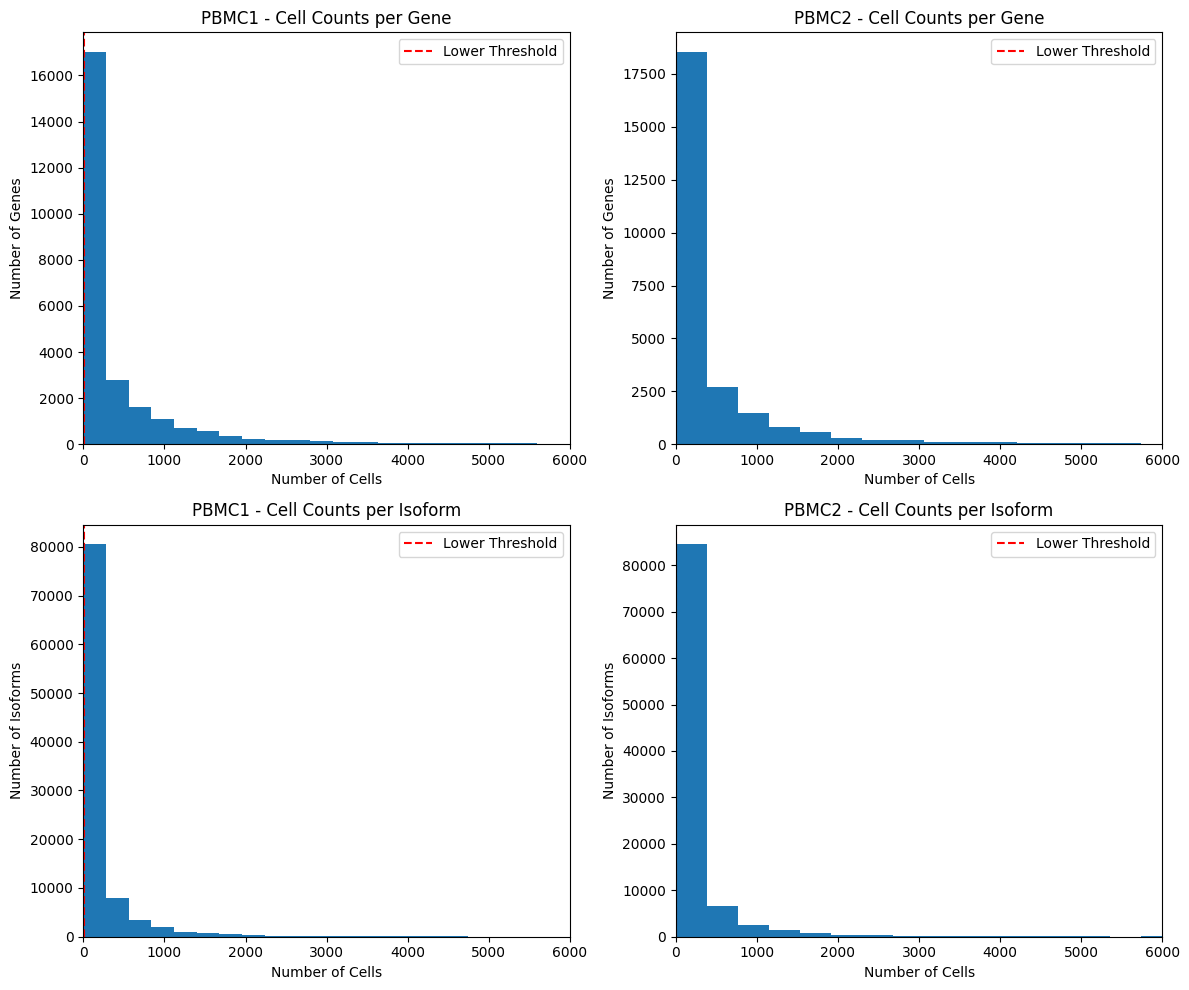

In [48]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # Use subplots properly

# Plot the distribution of cell counts per gene for PBMC1
axs[0, 0].hist(PBMC1_gene_counts, bins=100)
axs[0, 0].set_xlabel('Number of Cells')
axs[0, 0].set_ylabel('Number of Genes')
axs[0, 0].set_xlim(0, 6000)
axs[0, 0].set_title('PBMC1 - Cell Counts per Gene')
axs[0, 0].axvline(5, color='r', linestyle='--', label='Lower Threshold')
axs[0, 0].legend()

# Plot the distribution of cell counts per gene for PBMC2
axs[0, 1].hist(PBMC2_gene_counts, bins=100)
axs[0, 1].set_xlabel('Number of Cells')
axs[0, 1].set_ylabel('Number of Genes')
axs[0, 1].set_xlim(0, 6000)
axs[0, 1].set_title('PBMC2 - Cell Counts per Gene')
axs[0, 1].axvline(5, color='r', linestyle='--', label='Lower Threshold')
axs[0, 1].legend()

# Plot the distribution of cell counts per isoform for PBMC1
axs[1, 0].hist(PBMC1_iso_counts, bins=100)
axs[1, 0].set_xlabel('Number of Cells')
axs[1, 0].set_ylabel('Number of Isoforms')
axs[1, 0].set_xlim(0, 6000)
axs[1, 0].set_title('PBMC1 - Cell Counts per Isoform')
axs[1, 0].axvline(5, color='r', linestyle='--', label='Lower Threshold')
axs[1, 0].legend()

# Plot the distribution of cell counts per isoform for PBMC2
axs[1, 1].hist(PBMC2_iso_counts, bins=100)
axs[1, 1].set_xlabel('Number of Cells')
axs[1, 1].set_ylabel('Number of Isoforms')
axs[1, 1].set_xlim(0, 6000)
axs[1, 1].set_title('PBMC2 - Cell Counts per Isoform')
axs[1, 1].axvline(5, color='r', linestyle='--', label='Lower Threshold')
axs[1, 1].legend()

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [49]:
# Combine PBMC1 and PBMC2 datasets for plotting
import anndata as ad  # Import anndata explicitly

combined_gene = ad.concat([PBMC1_gene, PBMC2_gene], join="inner")
combined_iso = ad.concat([PBMC1_iso, PBMC2_iso], join="inner")

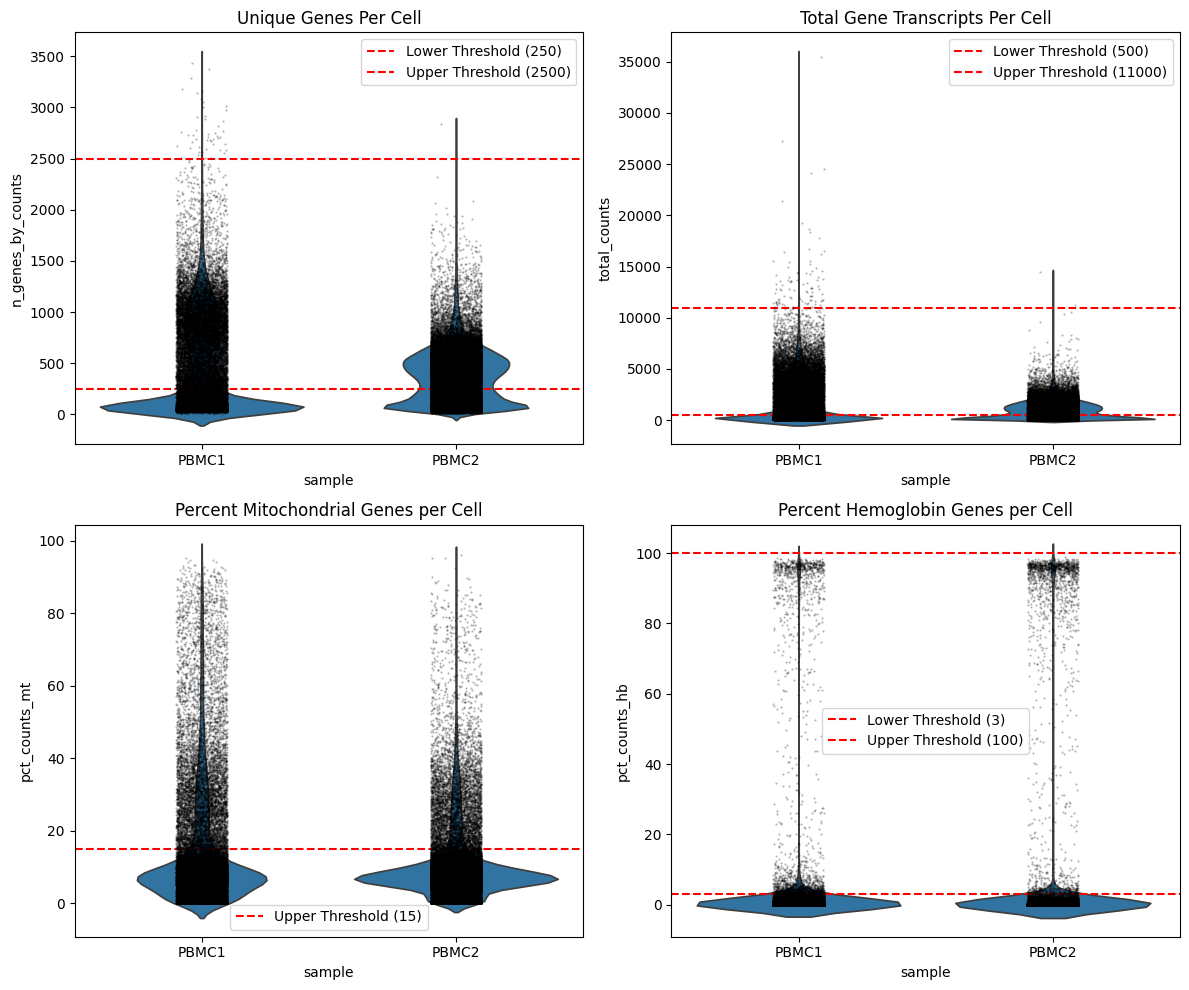

In [50]:
# Plot QC metrics for genes
fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # Create a 2x2 grid of subplots

plot_violin_with_thresholds(combined_gene, "n_genes_by_counts", 
                            "Unique Genes Per Cell", n_genes_lower_threshold, n_genes_upper_threshold, ax=axs[0, 0])

plot_violin_with_thresholds(combined_gene, "total_counts", 
                            "Total Gene Transcripts Per Cell", total_counts_lower_threshold, total_counts_upper_threshold, ax=axs[0, 1])

plot_violin_with_thresholds(combined_gene, "pct_counts_mt", 
                            "Percent Mitochondrial Genes per Cell", None, mt_upper_threshold, ax=axs[1, 0])

plot_violin_with_thresholds(combined_gene, "pct_counts_hb", 
                            "Percent Hemoglobin Genes per Cell", hb_lower_threshold, hb_upper_threshold, ax=axs[1, 1])

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

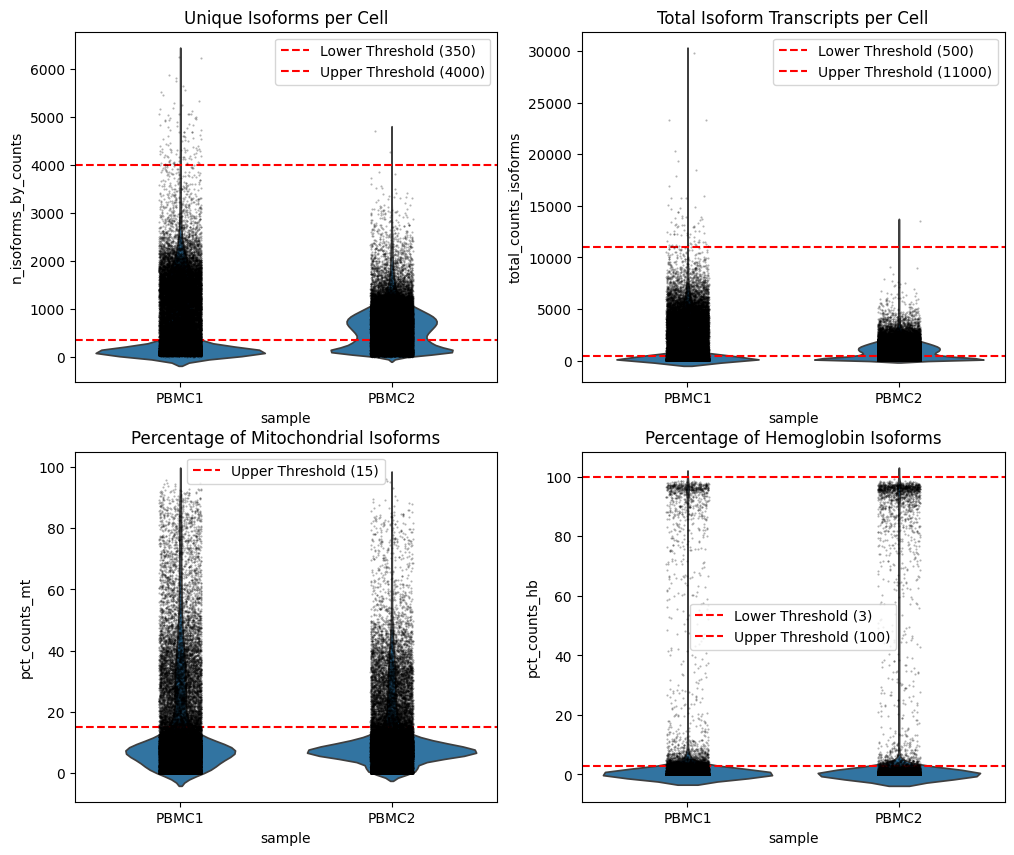

In [51]:
# Plot QC metrics for isoforms (adjusted column names)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # Create a 2x2 grid of subplots

plot_violin_with_thresholds(combined_iso, "n_isoforms_by_counts", "Unique Isoforms per Cell", n_isoforms_lower_threshold, n_isoforms_upper_threshold, ax=axs[0, 0])
plot_violin_with_thresholds(combined_iso, "total_counts_isoforms", "Total Isoform Transcripts per Cell", total_counts_lower_threshold, total_counts_upper_threshold, ax=axs[0, 1])
plot_violin_with_thresholds(combined_iso, "pct_counts_mt", "Percentage of Mitochondrial Isoforms", None, mt_upper_threshold, ax=axs[1, 0])
plot_violin_with_thresholds(combined_iso, "pct_counts_hb", "Percentage of Hemoglobin Isoforms", hb_lower_threshold, hb_upper_threshold, ax=axs[1, 1])

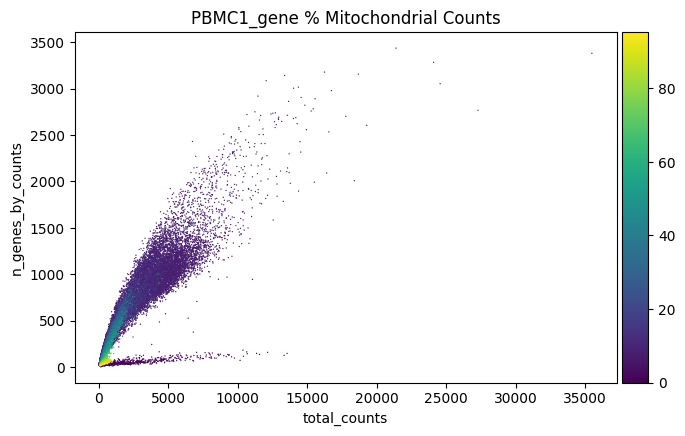

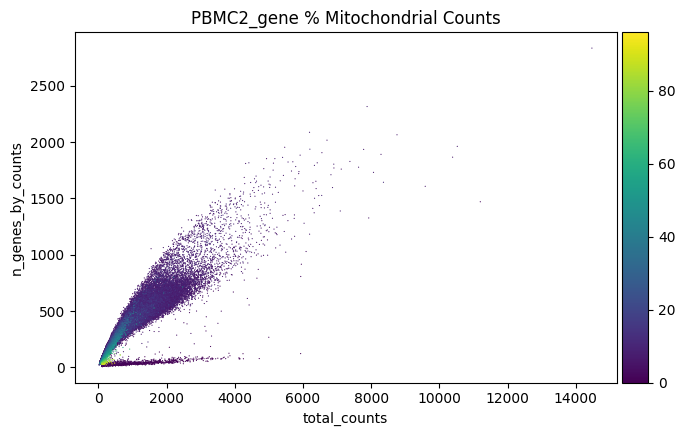

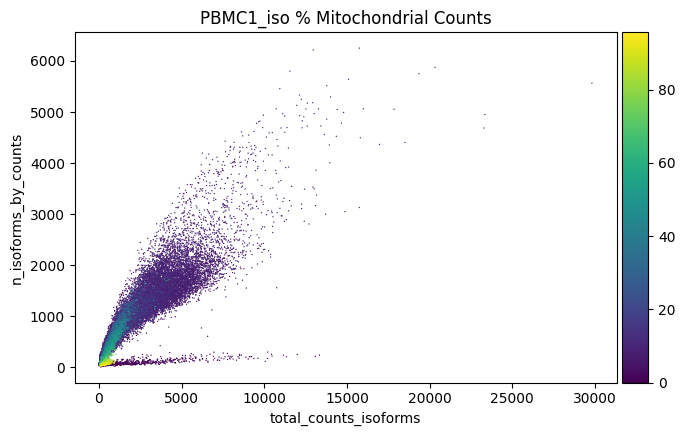

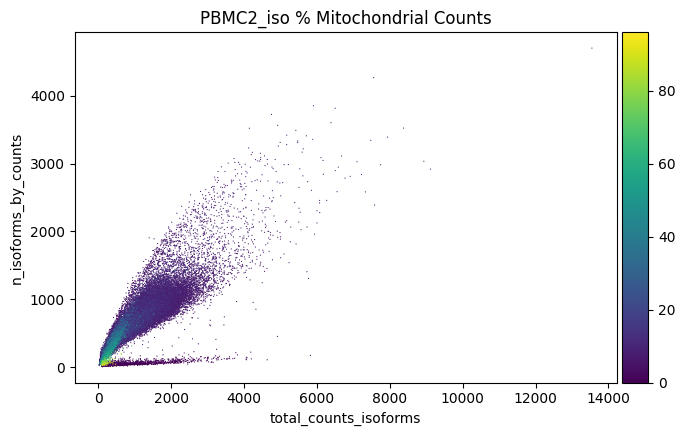

In [52]:
import scanpy as sc
import matplotlib.pyplot as plt

# Plot scatter for PBMC1 Gene
sc.pl.scatter(PBMC1_gene, "total_counts", "n_genes_by_counts", color="pct_counts_mt", title="PBMC1_gene % Mitochondrial Counts")
plt.show()

# Plot scatter for PBMC2 Gene
sc.pl.scatter(PBMC2_gene, "total_counts", "n_genes_by_counts", color="pct_counts_mt", title="PBMC2_gene % Mitochondrial Counts")
plt.show()

# Plot scatter for PBMC1 Isoform
sc.pl.scatter(PBMC1_iso, "total_counts_isoforms", "n_isoforms_by_counts", color="pct_counts_mt", title="PBMC1_iso % Mitochondrial Counts")
plt.show()

# Plot scatter for PBMC2 Isoform
sc.pl.scatter(PBMC2_iso, "total_counts_isoforms", "n_isoforms_by_counts", color="pct_counts_mt", title="PBMC2_iso % Mitochondrial Counts")
plt.show()

In [53]:
# Assuming PBMC1_gene is an AnnData object, extract the isoform IDs from var_names
P1_isoform_IDs = PBMC1_iso.var_names

# Convert to a list (if needed)
P1_isoform_ID_list = P1_isoform_IDs.tolist()

# Print the first few isoform IDs to verify
print(P1_isoform_ID_list[:10])  # Show the first 10 isoform IDs

# Assuming PBMC1_gene is an AnnData object, extract the isoform IDs from var_names
P2_isoform_IDs = PBMC2_iso.var_names

# Convert to a list (if needed)
P2_isoform_ID_list = P2_isoform_IDs.tolist()

# Print the first few isoform IDs to verify
print(P2_isoform_ID_list[:10])  # Show the first 10 isoform IDs

['BambuGene1021:BambuTx3', 'BambuGene10315:BambuTx20', 'BambuGene1277:BambuTx5', 'BambuGene13114:BambuTx22', 'BambuGene13851:BambuTx24', 'BambuGene14461:BambuTx25', 'BambuGene15305:BambuTx26', 'BambuGene17689:BambuTx29', 'BambuGene17932:BambuTx31', 'BambuGene19:BambuTx109']
['BambuGene1021:BambuTx3', 'BambuGene10315:BambuTx20', 'BambuGene1277:BambuTx5', 'BambuGene13114:BambuTx22', 'BambuGene13851:BambuTx24', 'BambuGene14461:BambuTx25', 'BambuGene15305:BambuTx26', 'BambuGene15308:BambuTx27', 'BambuGene17689:BambuTx29', 'BambuGene17932:BambuTx31']


In [54]:
# Function to plot QC metrics with thresholds
def plot_violin_with_thresholds(adata, metric, title, lower_thresh=None, upper_thresh=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))  # Create a new figure if no axis is provided
    
    sns.violinplot(x='sample', y=metric, data=adata.obs, inner=None, ax=ax)
    sns.stripplot(x='sample', y=metric, data=adata.obs, color='k', jitter=True, size=1.5, ax=ax)
    
    if lower_thresh is not None:
        ax.axhline(y=lower_thresh, color='r', linestyle='--', label=f'Lower Threshold ({lower_thresh})')
    if upper_thresh is not None:
        ax.axhline(y=upper_thresh, color='r', linestyle='--', label=f'Upper Threshold ({upper_thresh})')

    ax.set_title(title)
    ax.legend()

In [55]:
## Filter cells based on quality control metrics

PBMC1_g_filtered = PBMC1_gene[
    (PBMC1_gene.obs['total_counts'].between(total_counts_lower_threshold, total_counts_upper_threshold)) &
    (PBMC1_gene.obs['n_genes_by_counts'].between(n_genes_lower_threshold, n_genes_upper_threshold)) &
    (PBMC1_gene.obs['pct_counts_mt'] < mt_upper_threshold) &
    ((PBMC1_gene.obs['pct_counts_hb'] <= hb_lower_threshold) | (PBMC1_gene.obs['pct_counts_hb'] >= hb_upper_threshold)),
    :
]

PBMC2_g_filtered = PBMC2_gene[
    (PBMC2_gene.obs['total_counts'].between(total_counts_lower_threshold, total_counts_upper_threshold)) &
    (PBMC2_gene.obs['n_genes_by_counts'].between(n_genes_lower_threshold, n_genes_upper_threshold)) &
    (PBMC2_gene.obs['pct_counts_mt'] < mt_upper_threshold) &
    ((PBMC2_gene.obs['pct_counts_hb'] <= hb_lower_threshold) | (PBMC2_gene.obs['pct_counts_hb'] >= hb_upper_threshold)),
    :
]

PBMC1_i_filtered = PBMC1_iso[
    (PBMC1_iso.obs['total_counts_isoforms'].between(total_counts_lower_threshold, total_counts_upper_threshold)) &
    (PBMC1_iso.obs['n_isoforms_by_counts'].between(n_isoforms_lower_threshold, n_isoforms_upper_threshold)) &
    (PBMC1_iso.obs['pct_counts_mt'] < mt_upper_threshold) &
    ((PBMC1_iso.obs['pct_counts_hb'] <= hb_lower_threshold) | (PBMC1_iso.obs['pct_counts_hb'] >= hb_upper_threshold)),
    :
]

PBMC2_i_filtered = PBMC2_iso[
    (PBMC2_iso.obs['total_counts_isoforms'].between(total_counts_lower_threshold, total_counts_upper_threshold)) &
    (PBMC2_iso.obs['n_isoforms_by_counts'].between(n_isoforms_lower_threshold, n_isoforms_upper_threshold)) &
    (PBMC2_iso.obs['pct_counts_mt'] < mt_upper_threshold) &
    ((PBMC2_iso.obs['pct_counts_hb'] <= hb_lower_threshold) | (PBMC2_iso.obs['pct_counts_hb'] >= hb_upper_threshold)),
    :
]

sc.pp.filter_genes(PBMC1_g_filtered, min_cells=lower_threshold)

sc.pp.filter_genes(PBMC2_g_filtered, min_cells=lower_threshold)

sc.pp.filter_genes(PBMC1_i_filtered, min_cells=lower_threshold)

sc.pp.filter_genes(PBMC2_i_filtered, min_cells=lower_threshold)

/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:287: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number
/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:287: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number
/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:287: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number
/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:287: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


In [56]:
# Post QC cell counts
post_qc_cell_counts_1g = PBMC1_g_filtered.n_obs
post_qc_cell_counts_2g = PBMC2_g_filtered.n_obs
post_qc_cell_counts_1i = PBMC1_i_filtered.n_obs
post_qc_cell_counts_2i = PBMC2_i_filtered.n_obs

post_qc_cell_counts_df = pd.DataFrame({
    'Sample': ['PBMC1 Gene', 'PBMC2 Gene', 'PBMC1 Isoform', 'PBMC2 Isoform'],
    'Initial Cell #': [init_cell_counts_1g, init_cell_counts_2g, init_cell_counts_1i, init_cell_counts_2i],
    'Post QC Counts': [post_qc_cell_counts_1g, post_qc_cell_counts_2g, post_qc_cell_counts_1i, post_qc_cell_counts_2i],
    'Percent Remaining': [post_qc_cell_counts_1g / init_cell_counts_1g * 100, post_qc_cell_counts_2g / init_cell_counts_2g * 100, 
                          post_qc_cell_counts_1i / init_cell_counts_1i * 100, post_qc_cell_counts_2i / init_cell_counts_2i * 100]
})

print(post_qc_cell_counts_df)

          Sample  Initial Cell #  Post QC Counts  Percent Remaining
0     PBMC1 Gene           32939           12662          38.440754
1     PBMC2 Gene           42393           24407          57.573184
2  PBMC1 Isoform           32939           12389          37.611949
3  PBMC2 Isoform           42393           24098          56.844290


In [57]:
# Recalculate the number of cells in which each gene is detected after filtering
PBMC1_gene_counts_filtered = np.sum(PBMC1_g_filtered.X > 0, axis=0).A1 if isinstance(PBMC1_g_filtered.X, np.matrix) else np.sum(PBMC1_g_filtered.X > 0, axis=0)

PBMC2_gene_counts_filtered = np.sum(PBMC2_g_filtered.X > 0, axis=0).A1 if isinstance(PBMC2_g_filtered.X, np.matrix) else np.sum(PBMC2_g_filtered.X > 0, axis=0)

In [58]:
# Combine PBMC1 and PBMC2 datasets for plotting
import anndata as ad  # Import anndata explicitly

combined_gene_filtered = ad.concat([PBMC1_g_filtered, PBMC2_g_filtered], join="inner")
combined_iso_filtered = ad.concat([PBMC1_i_filtered, PBMC2_i_filtered], join="inner")

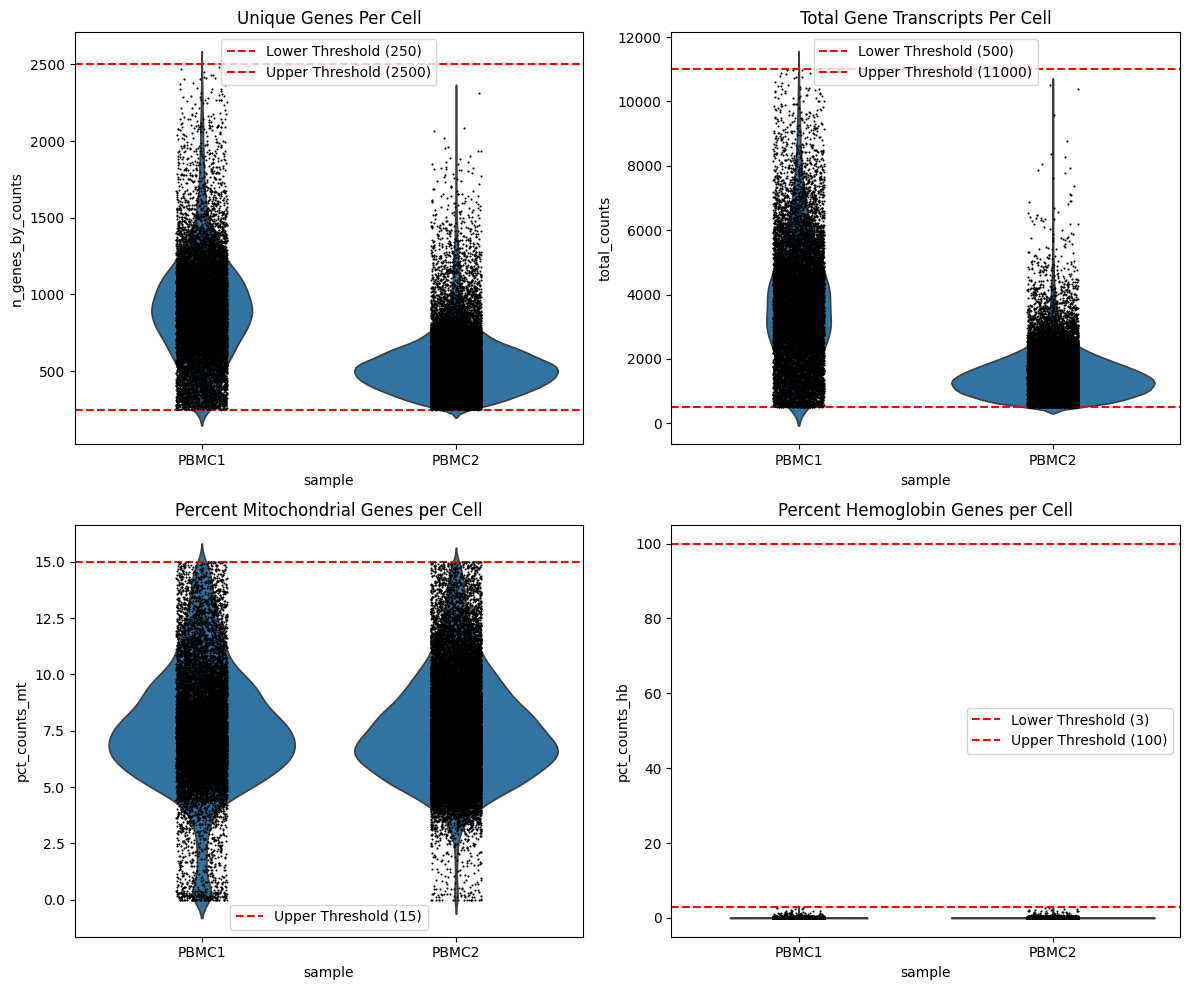

In [59]:
# Plot QC metrics for genes
fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # Create a 2x2 grid of subplots

plot_violin_with_thresholds(combined_gene_filtered, "n_genes_by_counts", 
                            "Unique Genes Per Cell", n_genes_lower_threshold, n_genes_upper_threshold, ax=axs[0, 0])

plot_violin_with_thresholds(combined_gene_filtered, "total_counts", 
                            "Total Gene Transcripts Per Cell", total_counts_lower_threshold, total_counts_upper_threshold, ax=axs[0, 1])

plot_violin_with_thresholds(combined_gene_filtered, "pct_counts_mt", 
                            "Percent Mitochondrial Genes per Cell", None, mt_upper_threshold, ax=axs[1, 0])

plot_violin_with_thresholds(combined_gene_filtered, "pct_counts_hb", 
                            "Percent Hemoglobin Genes per Cell", hb_lower_threshold, hb_upper_threshold, ax=axs[1, 1])

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

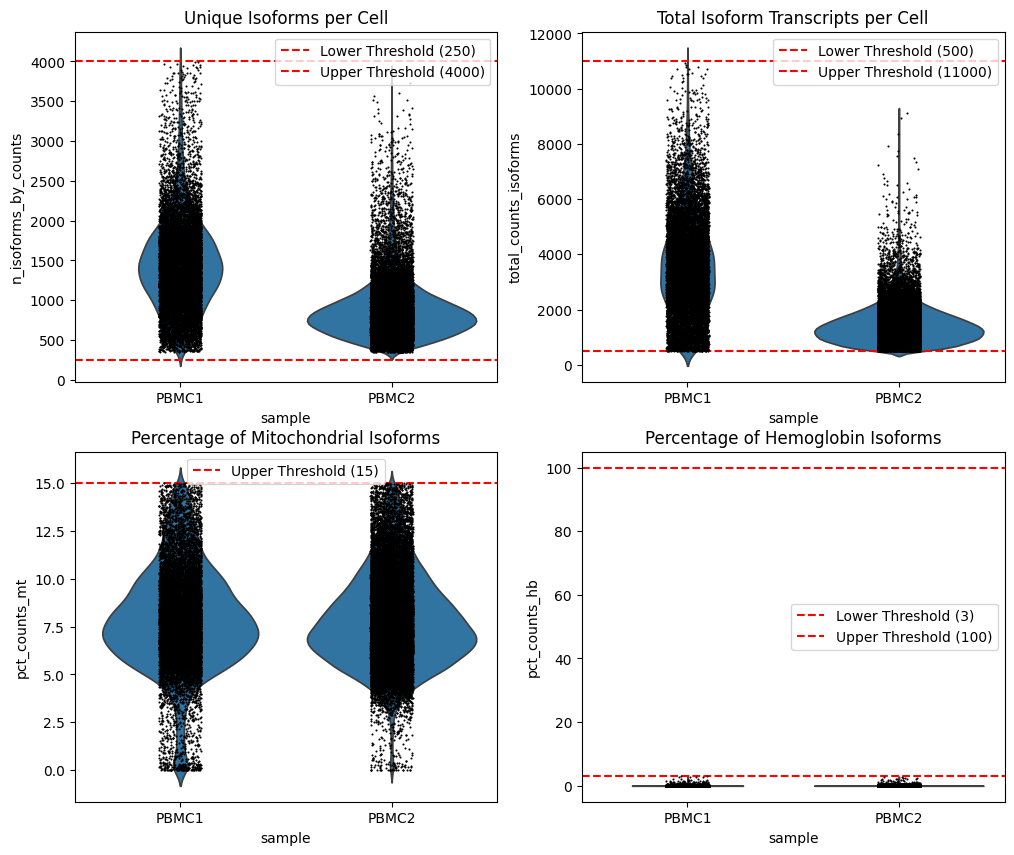

In [60]:
# Plot QC metrics for isoforms (adjusted column names)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # Create a 2x2 grid of subplots

plot_violin_with_thresholds(combined_iso_filtered, "n_isoforms_by_counts", "Unique Isoforms per Cell", n_genes_lower_threshold, n_isoforms_upper_threshold, ax=axs[0, 0])
plot_violin_with_thresholds(combined_iso_filtered, "total_counts_isoforms", "Total Isoform Transcripts per Cell", total_counts_lower_threshold, total_counts_upper_threshold, ax=axs[0, 1])
plot_violin_with_thresholds(combined_iso_filtered, "pct_counts_mt", "Percentage of Mitochondrial Isoforms", None, mt_upper_threshold, ax=axs[1, 0])
plot_violin_with_thresholds(combined_iso_filtered, "pct_counts_hb", "Percentage of Hemoglobin Isoforms", hb_lower_threshold, hb_upper_threshold, ax=axs[1, 1])

In [61]:
int_folder = "Intermediate_Files/QC_Figs_04302025"

# File paths with properly formatted names
pbmc1_g_path = os.path.join(int_folder, "PBMC1_gene_AnnData_filtered_04302025.h5ad")
pbmc2_g_path = os.path.join(int_folder, "PBMC2_gene_AnnData_filtered_04302025.h5ad")
pbmc1_i_path = os.path.join(int_folder, "PBMC1_iso_AnnData_filtered_04302025.h5ad")
pbmc2_i_path = os.path.join(int_folder, "PBMC2_iso_AnnData_filtered_04302025.h5ad")

PBMC1_g_filtered.write_h5ad(pbmc1_g_path, compression="gzip")
PBMC2_g_filtered.write_h5ad(pbmc2_g_path, compression="gzip")
PBMC1_i_filtered.write_h5ad(pbmc1_i_path, compression="gzip")
PBMC2_i_filtered.write_h5ad(pbmc2_i_path, compression="gzip")

In [62]:
from anndata import read_h5ad

# Define the folder path
folder_path = "Intermediate_Files/QC_Figs_04302025"

# Load the AnnData objects
PBMC1_g_filtered = read_h5ad(os.path.join(folder_path, 
                                     "PBMC1_gene_AnnData_filtered_04302025.h5ad"))
PBMC2_g_filtered = read_h5ad(os.path.join(folder_path, 
                                     "PBMC2_gene_AnnData_filtered_04302025.h5ad"))
PBMC1_i_filtered = read_h5ad(os.path.join(folder_path, 
                                     "PBMC1_iso_AnnData_filtered_04302025.h5ad"))
PBMC2_i_filtered = read_h5ad(os.path.join(folder_path, 
                                     "PBMC2_iso_AnnData_filtered_04302025.h5ad"))

In [63]:
# Verify the structure
print(PBMC1_g_filtered)
print(PBMC2_g_filtered)
print(PBMC1_i_filtered)
print(PBMC2_i_filtered)

AnnData object with n_obs × n_vars = 12662 × 21051
    obs: 'cell_ids', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'mt', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
AnnData object with n_obs × n_vars = 24407 × 20690
    obs: 'cell_ids', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'mt', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
AnnData object with n_obs × n_vars = 12389 × 72484
    obs: 'cell_ids', 'sample', 'n_isoforms_by

In [64]:
import numpy as np

# Convert sparse matrix to dense format before checking NaNs
print("Initial NaN values in the data matrix:", np.isnan(PBMC1_g_filtered.X.toarray()).sum())
print("Initial NaN values in the data matrix:", np.isnan(PBMC2_g_filtered.X.toarray()).sum())
print("Initial NaN values in the data matrix:", np.isnan(PBMC1_i_filtered.X.toarray()).sum())
print("Initial NaN values in the data matrix:", np.isnan(PBMC2_i_filtered.X.toarray()).sum())

Initial NaN values in the data matrix: 0
Initial NaN values in the data matrix: 0
Initial NaN values in the data matrix: 0
Initial NaN values in the data matrix: 0


In [65]:
from scipy.sparse import issparse

print("PBMC1_gene sparse:", issparse(PBMC1_g_filtered.X))
print("PBMC2_gene sparse:", issparse(PBMC2_g_filtered.X))
print("PBMC1_iso sparse:", issparse(PBMC1_i_filtered.X))
print("PBMC2_iso sparse:", issparse(PBMC2_i_filtered.X))

PBMC1_gene sparse: True
PBMC2_gene sparse: True
PBMC1_iso sparse: True
PBMC2_iso sparse: True


In [66]:
import anndata

# Concatenate the two AnnData objects
adata_g_filter = anndata.concat([PBMC1_g_filtered, PBMC2_g_filtered], join="inner", label="batch", keys=["PBMC1_gene", "PBMC2_gene"])
# Verify the result
print(adata_g_filter)
print(adata_g_filter.obs["batch"].value_counts())

AnnData object with n_obs × n_vars = 37069 × 19911
    obs: 'cell_ids', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'batch'
batch
PBMC2_gene    24407
PBMC1_gene    12662
Name: count, dtype: int64


In [67]:
import anndata
adata_i_filter = anndata.concat([PBMC1_i_filtered, PBMC2_i_filtered], join="inner", label="batch", keys=["PBMC1_iso", "PBMC2_iso"])

In [68]:
# Define the folder path
Int_folder = "Intermediate_Files/QC_Figs_04302025"

# Save the AnnData objects
adata_g_filter.write(os.path.join(Int_folder, "Concatenated_Gene_Data_04302025.h5ad"))
adata_i_filter.write(os.path.join(Int_folder, "Concatenated_Iso_Data_04302025.h5ad"))

In [ ]:
### START HERE ###

In [69]:
from anndata import read_h5ad

# Define the folder path
Int_folder = "Intermediate_Files/QC_Figs_04302025"

# Load the AnnData objects
adata_g_filter = read_h5ad(os.path.join(Int_folder, "Concatenated_Gene_Data_04302025.h5ad"))
adata_i_filter = read_h5ad(os.path.join(Int_folder, "Concatenated_Iso_Data_04302025.h5ad"))

In [70]:
# Verify the structure
print(adata_g_filter)
print("")
print(adata_i_filter)

AnnData object with n_obs × n_vars = 37069 × 19911
    obs: 'cell_ids', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'batch'

AnnData object with n_obs × n_vars = 36487 × 67476
    obs: 'cell_ids', 'sample', 'n_isoforms_by_counts', 'log1p_n_genes_by_counts', 'total_counts_isoforms', 'log1p_total_counts_isoforms', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'batch'


In [71]:
# Convert Matrices to Dense for Scrublet
adata_g_filter.X = adata_g_filter.X.toarray()
adata_i_filter.X = adata_i_filter.X.toarray()

In [72]:
# Confirm that datasets are dense matrices. If so, commands will return "False"
from scipy.sparse import issparse

print("PBMC_gene sparse:", issparse(adata_g_filter.X))
print("PBMC_iso sparse:", issparse(adata_i_filter.X))

PBMC_gene sparse: False
PBMC_iso sparse: False


In [73]:
## Check For Doublets
sc.pp.scrublet(adata_g_filter, batch_key="batch")
sc.pp.scrublet(adata_i_filter, batch_key="batch")

In [74]:
from skimage.filters import threshold_minimum

## Calculate the automatic threshold using Scrublet's method
auto_gene_threshold_PBMC = threshold_minimum(adata_g_filter.obs['doublet_score'].values)
auto_iso_threshold_PBMC = threshold_minimum(adata_i_filter.obs['doublet_score'].values)


# Set initial threshold to mark 14% of cells as doublets
manual_gene_threshold_PBMC = np.percentile(adata_g_filter.obs['doublet_score'], 86)
manual_iso_threshold_PBMC = np.percentile(adata_i_filter.obs['doublet_score'], 86)

# Debugging: Print the calculated manual threshold and check the 86th percentile
print(f"Manual threshold (86th percentile): {manual_gene_threshold_PBMC:.3f}")
print(f"Manual threshold (86th percentile): {manual_iso_threshold_PBMC:.3f}")
print(f"86th percentile value in doublet scores: {np.percentile(adata_g_filter.obs['doublet_score'], 86):.3f}")
print(f"86th percentile value in doublet scores: {np.percentile(adata_i_filter.obs['doublet_score'], 86):.3f}")

Manual threshold (86th percentile): 0.138
Manual threshold (86th percentile): 0.164
86th percentile value in doublet scores: 0.138
86th percentile value in doublet scores: 0.164


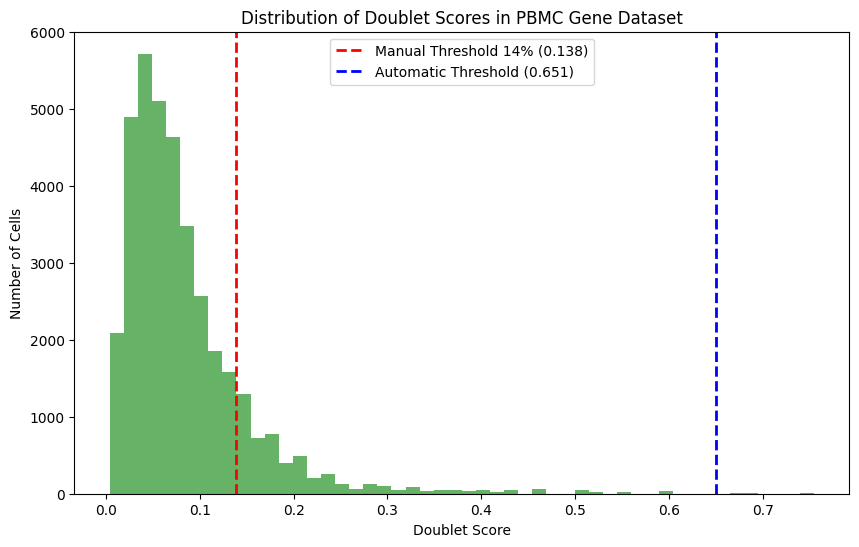

In [75]:
# Plot the gene histogram of doublet scores with both thresholds
plt.figure(figsize=(10, 6))
plt.hist(adata_g_filter.obs['doublet_score'], bins=50, alpha=0.6, color='g')
plt.axvline(manual_gene_threshold_PBMC, color='r', linestyle='dashed', linewidth=2, label=f'Manual Threshold 14% ({manual_gene_threshold_PBMC:.3f})')
plt.axvline(auto_gene_threshold_PBMC, color='b', linestyle='dashed', linewidth=2, label=f'Automatic Threshold ({auto_gene_threshold_PBMC:.3f})')
plt.xlabel('Doublet Score')
plt.ylabel('Number of Cells')
plt.title('Distribution of Doublet Scores in PBMC Gene Dataset')
plt.legend()
plt.show()

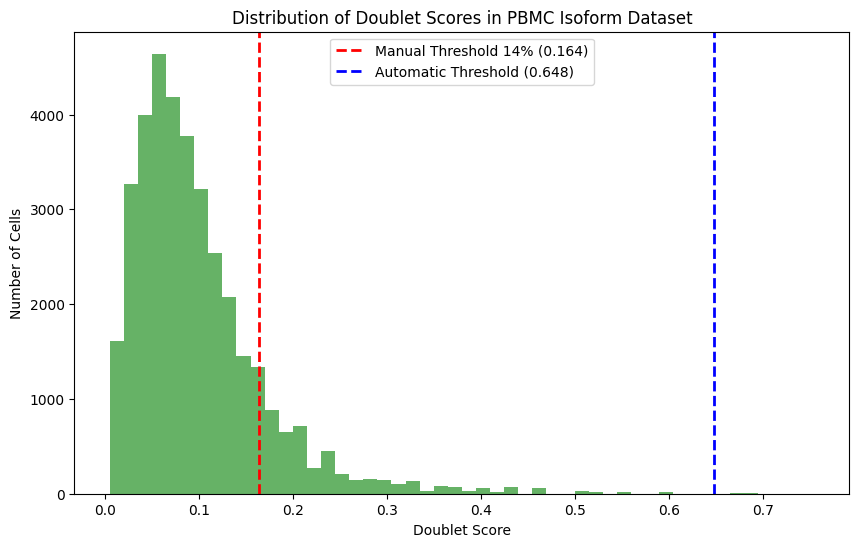

In [76]:
# Plot the Isoform histogram of doublet scores with both thresholds
plt.figure(figsize=(10, 6))
plt.hist(adata_i_filter.obs['doublet_score'], bins=50, alpha=0.6, color='g')
plt.axvline(manual_iso_threshold_PBMC, color='r', linestyle='dashed', linewidth=2, label=f'Manual Threshold 14% ({manual_iso_threshold_PBMC:.3f})')
plt.axvline(auto_iso_threshold_PBMC, color='b', linestyle='dashed', linewidth=2, label=f'Automatic Threshold ({auto_iso_threshold_PBMC:.3f})')
plt.xlabel('Doublet Score')
plt.ylabel('Number of Cells')
plt.title('Distribution of Doublet Scores in PBMC Isoform Dataset')
plt.legend()
plt.show()

In [77]:
# Set final threshold where threshold starts to level out
gene_threshold = 0.3
iso_threshold = 0.3

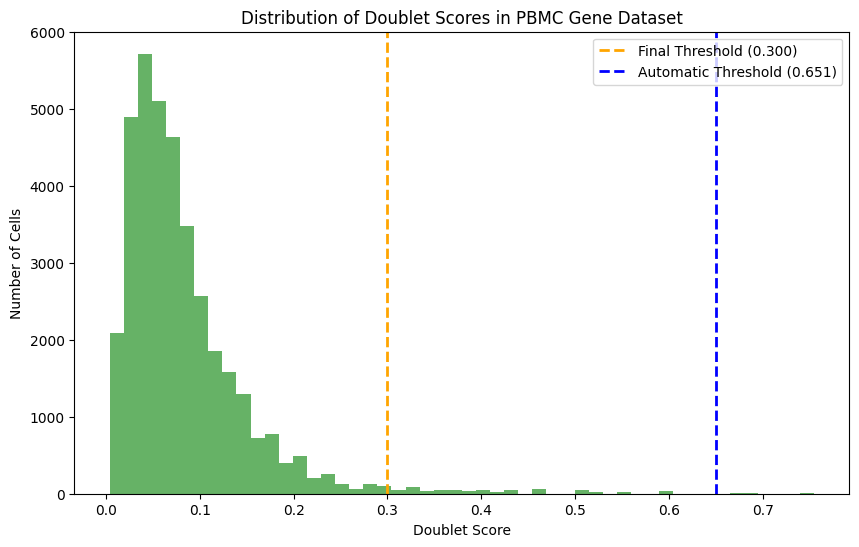

In [78]:
# Plot the histogram of doublet scores with all 3 thresholds
plt.figure(figsize=(10, 6))
plt.hist(adata_g_filter.obs['doublet_score'], bins=50, alpha=0.6, color='g')
#plt.axvline(manual_gene_threshold_PBMC, color='r', linestyle='dashed', linewidth=2, label=f'Manual Threshold ({manual_gene_threshold_PBMC:.3f})')
plt.axvline(gene_threshold, color='orange', linestyle='dashed', linewidth=2, label=f'Final Threshold ({gene_threshold:.3f})')
plt.axvline(auto_gene_threshold_PBMC, color='b', linestyle='dashed', linewidth=2, label=f'Automatic Threshold ({auto_gene_threshold_PBMC:.3f})')
plt.xlabel('Doublet Score')
plt.ylabel('Number of Cells')
plt.title('Distribution of Doublet Scores in PBMC Gene Dataset')
plt.legend()
plt.show()

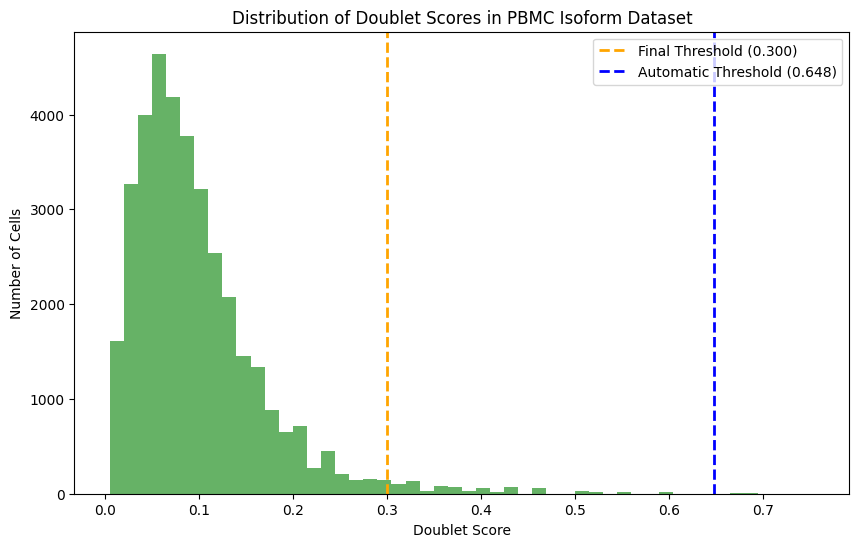

In [79]:
# Plot the histogram of doublet scores with all 3 thresholds
plt.figure(figsize=(10, 6))
plt.hist(adata_i_filter.obs['doublet_score'], bins=50, alpha=0.6, color='g')
#plt.axvline(manual_iso_threshold_PBMC, color='r', linestyle='dashed', linewidth=2, label=f'Manual Threshold ({manual_iso_threshold_PBMC:.3f})')
plt.axvline(iso_threshold, color='orange', linestyle='dashed', linewidth=2, label=f'Final Threshold ({iso_threshold:.3f})')
plt.axvline(auto_iso_threshold_PBMC, color='b', linestyle='dashed', linewidth=2, label=f'Automatic Threshold ({auto_iso_threshold_PBMC:.3f})')
plt.xlabel('Doublet Score')
plt.ylabel('Number of Cells')
plt.title('Distribution of Doublet Scores in PBMC Isoform Dataset')
plt.legend()
plt.show()

In [80]:
# Add doublet scores to AnnData object
#adata_g_filter.obs['predicted_doublet_manual'] = adata_g_filter.obs['doublet_score'] > manual_gene_threshold_PBMC
adata_g_filter.obs['predicted_doublet_auto'] = adata_g_filter.obs['doublet_score'] > auto_gene_threshold_PBMC
adata_g_filter.obs['predicted_doublet_final'] = adata_g_filter.obs['doublet_score'] > gene_threshold

#print(f"Manual threshold: {manual_gene_threshold_PBMC}")
print(f"Automatic threshold: {auto_gene_threshold_PBMC}")
print(f"Final threshold: {gene_threshold}")
#print(f"Number of cells predicted as doublets with manual threshold: {adata_g_filter.obs['predicted_doublet_manual'].sum()}")
print(f"Number of cells predicted as doublets with automatic threshold: {adata_g_filter.obs['predicted_doublet_auto'].sum()}")
print(f"Number of cells predicted as doublets with final threshold: {adata_g_filter.obs['predicted_doublet_final'].sum()}")

Automatic threshold: 0.6506932271611432
Final threshold: 0.3
Number of cells predicted as doublets with automatic threshold: 18
Number of cells predicted as doublets with final threshold: 606


In [81]:
# Add doublet scores to AnnData object
#adata_i_filter.obs['predicted_doublet_manual'] = adata_i_filter.obs['doublet_score'] > manual_iso_threshold_PBMC
adata_i_filter.obs['predicted_doublet_auto'] = adata_i_filter.obs['doublet_score'] > auto_iso_threshold_PBMC
adata_i_filter.obs['predicted_doublet_final'] = adata_i_filter.obs['doublet_score'] > iso_threshold

#print(f"Manual threshold: {manual_iso_threshold_PBMC}")
print(f"Automatic threshold: {auto_iso_threshold_PBMC}")
print(f"Final threshold: {iso_threshold}")
#print(f"Number of cells predicted as doublets with manual threshold: {adata_i_filter.obs['predicted_doublet_manual'].sum()}")
print(f"Number of cells predicted as doublets with automatic threshold: {adata_i_filter.obs['predicted_doublet_auto'].sum()}")
print(f"Number of cells predicted as doublets with final threshold: {adata_i_filter.obs['predicted_doublet_final'].sum()}")

Automatic threshold: 0.647865584653772
Final threshold: 0.3
Number of cells predicted as doublets with automatic threshold: 11
Number of cells predicted as doublets with final threshold: 755


In [82]:
# Filter out predicted doublets using the final threshold
adata_g_std_filtered = adata_g_filter[~adata_g_filter.obs['predicted_doublet_final']]
adata_i_std_filtered = adata_i_filter[~adata_i_filter.obs['predicted_doublet_final']]

print(f"Number of cells in Gene dataset before filtering: {adata_g_filter.shape[0]}")
print(f"Number of cells in Isoform dataset before filtering: {adata_i_filter.shape[0]}")
print(f"Number of cells in Gene dataset after filtering with final threshold: {adata_g_std_filtered.shape[0]}")
print(f"Number of cells in Isoform dataset after filtering with final threshold: {adata_i_std_filtered.shape[0]}")

Number of cells in Gene dataset before filtering: 37069
Number of cells in Isoform dataset before filtering: 36487
Number of cells in Gene dataset after filtering with final threshold: 36463
Number of cells in Isoform dataset after filtering with final threshold: 35732


In [83]:
#Convert back to sparse matrices for efficiency

from scipy.sparse import csr_matrix
adata_g_std_filtered.X = csr_matrix(adata_g_std_filtered.X)  # Converts to sparse format
adata_i_std_filtered.X = csr_matrix(adata_i_std_filtered.X)  # Converts to sparse format

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:617: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/tmp/ipykernel_2583942/1468961090.py:4: UserWarning: Trying to set a dense array with a sparse array on a view.Densifying the sparse array.This may incur excessive memory usage
  adata_g_std_filtered.X = csr_matrix(adata_g_std_filtered.X)  # Converts to sparse format
/tmp/ipykernel_2583942/1468961090.py:5: UserWarning: Trying to set a dense array with a sparse array on a view.Densifying the sparse array.This may incur excessive memory usage
  adata_i_std_filtered.X = csr_matrix(adata_i_std_filtered.X)  # Converts to sparse format


In [84]:
# Define the folder path
Int_folder = "Intermediate_Files/QC_Figs_04302025"

# Save the AnnData objects
adata_g_std_filtered.write(os.path.join(Int_folder, "Concatenated_Gene_Data_Filtered_PostScrublet_04302025.h5ad"))
adata_i_std_filtered.write(os.path.join(Int_folder, "Concatenated_Isoform_Data_Filtered_PostScrublet_04302025.h5ad"))

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


In [85]:
import numpy as np

# Assign sample label by batch
adata_g_std_filtered.obs["sample"] = adata_g_std_filtered.obs["batch"].astype(str)
adata_i_std_filtered.obs["sample"] = adata_i_std_filtered.obs["batch"].astype(str)

# Summary function
def compute_summary_stats(adata, is_isoform=False):
    sample_name = adata.obs['sample'].unique()[0]
    print(f"\n### Summary Stats for Sample: {sample_name} ({'Isoform' if is_isoform else 'Gene'})")

    if not is_isoform:
        total_counts = adata.obs['total_counts']
        unique_features = adata.obs['n_genes_by_counts']
        mt_percentage = adata.obs['pct_counts_mt']

        print("\n--- Total Gene Counts ---")
        print(f"Min: {total_counts.min()}")
        print(f"Median: {np.median(total_counts)}")
        print(f"Mean: {total_counts.mean()}")
        print(f"Max: {total_counts.max()}")

        transcripts_per_gene = total_counts / unique_features
        print("\n--- Transcripts per Gene ---")
        print(f"Min: {transcripts_per_gene.min()}")
        print(f"Median: {np.median(transcripts_per_gene)}")
        print(f"Mean: {transcripts_per_gene.mean()}")
        print(f"Max: {transcripts_per_gene.max()}")

        print("\n--- Unique Genes per Cell ---")
        print(f"Min: {unique_features.min()}")
        print(f"Median: {np.median(unique_features)}")
        print(f"Mean: {unique_features.mean()}")
        print(f"Max: {unique_features.max()}")

        print("\n--- Mitochondrial Percentage ---")
        print(f"Min: {mt_percentage.min()}")
        print(f"Median: {np.median(mt_percentage)}")
        print(f"Mean: {mt_percentage.mean()}")
        print(f"Max: {mt_percentage.max()}")

    else:
        total_counts = adata.obs['total_counts_isoforms']
        unique_features = adata.obs['n_isoforms_by_counts']
        reads_per_isoform = np.array(adata.X.sum(axis=1)).flatten() / unique_features

        print("\n--- Total Isoform Counts ---")
        print(f"Min: {total_counts.min()}")
        print(f"Median: {np.median(total_counts)}")
        print(f"Mean: {total_counts.mean()}")
        print(f"Max: {total_counts.max()}")

        print("\n--- Reads per Isoform per Cell ---")
        print(f"Min: {reads_per_isoform.min()}")
        print(f"Median: {np.median(reads_per_isoform)}")
        print(f"Mean: {reads_per_isoform.mean()}")
        print(f"Max: {reads_per_isoform.max()}")

        print("\n--- Unique Isoforms per Cell ---")
        print(f"Min: {unique_features.min()}")
        print(f"Median: {np.median(unique_features)}")
        print(f"Mean: {unique_features.mean()}")
        print(f"Max: {unique_features.max()}")

# Run per batch
for batch in adata_g_filter.obs["batch"].unique():
    g_sample = adata_g_filter[adata_g_filter.obs["batch"] == batch].copy()
    compute_summary_stats(g_sample, is_isoform=False)

for batch in adata_i_filter.obs["batch"].unique():
    i_sample = adata_i_filter[adata_i_filter.obs["batch"] == batch].copy()
    compute_summary_stats(i_sample, is_isoform=True)


### Summary Stats for Sample: PBMC1 (Gene)

--- Total Gene Counts ---
Min: 500.99992
Median: 3564.9999700000003
Mean: 3704.850672400884
Max: 10995.000170000001

--- Transcripts per Gene ---
Min: 1.4944129329608937
Median: 3.8894582159781685
Mean: 3.9229311807414833
Max: 8.22689930184805

--- Unique Genes per Cell ---
Min: 250
Median: 895.0
Mean: 907.370162691518
Max: 2483

--- Mitochondrial Percentage ---
Min: 0.0
Median: 7.407300582996339
Mean: 7.631036446063222
Max: 14.995716409340318

### Summary Stats for Sample: PBMC2 (Gene)

--- Total Gene Counts ---
Min: 500.9998
Median: 1397.0000599999998
Mean: 1520.5746017634285
Max: 10523.99972

--- Transcripts per Gene ---
Min: 1.3286705128205127
Median: 2.6905830044843047
Mean: 2.726743044605888
Max: 5.978129698340874

--- Unique Genes per Cell ---
Min: 250
Median: 516.0
Mean: 546.9266603843159
Max: 2316

--- Mitochondrial Percentage ---
Min: 0.0
Median: 7.2781660114373095
Mean: 7.613600595983598
Max: 14.999998593750133

### Summary Stats 